In [1]:
from allensdk.brain_observatory.ecephys.dynamic_gating_ecephys_session import DynamicGatingEcephysSession

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os, glob
import scipy.signal
import matplotlib as mpl
import os
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
import ccf_utils
import analysis_utils

%load_ext autoreload
%autoreload 2

In [7]:
structure_tree = pd.read_csv(r"..\ccf_structure_tree_2017.csv")

In [6]:
#This directory was created and populated by ../batch_processing/run_4Hz_bursts.py 
burst_data_dir = r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\derived_table_info\4Hz_bursts\all_areas_using_minima_125window'

#This dir contains ccgs, burst times and burst triggered behavior traces for each session. Its populated by ../batch_processing/run_4Hz_analysis
data_dir = r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\derived_table_info\4Hz_bursts\session_analysis"

In [8]:
def triggered_average(timeseries, timestamps, alignment_times, time_before, time_after):

    aligned = []
    for al in alignment_times:
        start = al - time_before
        end = al + time_after
        aligned_trial = timeseries[(timestamps>=start)&(timestamps<end)]
        aligned.append(aligned_trial)
    
    return aligned

In [9]:
def load_numpy_data(glob_pattern):
    files = glob.glob(glob_pattern)
    file_data = []
    for f in files:
        data = np.load(f, allow_pickle=True)

        if '_running_triggered' in glob_pattern or 'pupil' in glob_pattern:
            if isinstance(data[0], pd.core.series.Series):
                data = [rr for rr in data if len(rr)>0]
                data = [rr.values for rr in data]
            data = np.array(data)
        
        file_data.append(data)
    return file_data

In [10]:
#Load metadata tables
master_stim = pd.read_csv(r"..\..\metadata_tables\master_stim_trials_table.csv")
units_rf = pd.read_csv(r"..\..\metadata_tables\units_with_rf_metrics.csv")
master_channels_table = pd.read_csv(r"..\..\metadata_tables\\channels_table.csv")
units_with_rf = units_rf.merge(master_channels_table, left_on='peak_channel_id', right_on='id', suffixes=[None, '_channel'])

In [19]:
all_burst_areas = glob.glob(os.path.join(burst_data_dir, '*_burst_times.npy'))
all_burst_areas = np.unique([os.path.basename(f).split('_')[1] for f in all_burst_areas])

sessions = os.listdir(data_dir)
# ccg_dict = {area: {} for area in all_burst_areas}

# session = sessions[0]

# session_hists = glob.glob(os.path.join(data_dir, session, '*_burst_time_session_histogram.npy'))
# pupil = load_numpy_data(os.path.join(data_dir, '*', 'VISp' + '_pupil_triggered_average.npy'))
# len(pupil)
# ccg_files = glob.glob(os.path.join(data_dir, '*', 'VISp' + '_' + 'VISp' + '_ccgs.npy'))
# len(ccg_files)


In [115]:
session_dir = os.path.join(data_dir, session)
session_areas = glob.glob(os.path.join(session_dir, '*_burst_times.npy'))
session_areas = np.unique([os.path.basename(f).split('_')[0] for f in session_areas])
area = 'VISp'
area2 = 'ORBm'
ccg_file = os.path.join(session_dir, f'{area}_{area2}_ccgs.npy')
ccgs = np.load(ccg_file)
ccgs.shape

(27, 200)

In [20]:
#Load burst-related data for each session
session_data = {s: {'ccgs': {}, 'random_ccgs': {}, 'pupil': {}, 'running': {}, 
                    'pupil_random': {}, 'running_random': {}, 
                    'behavior_hists': {}, 'passive_hists': {}, 
                    'psths': {}, 'rand_psths': {}} for s in sessions}
for session in sessions:

    session_dir = os.path.join(data_dir, session)
    session_areas = glob.glob(os.path.join(session_dir, '*_burst_times.npy'))
    session_burst_areas = np.unique([os.path.basename(f).split('_')[0] for f in session_areas])
    session_recorded_areas = glob.glob(os.path.join(session_dir, '*ccgs.npy'))
    session_recorded_areas = np.unique([os.path.basename(f).split('_')[1] for f in session_recorded_areas])

    session_dict = session_data[session]
    for area in session_burst_areas:
        pupil = load_numpy_data(os.path.join(session_dir, area + '_pupil_triggered_average.npy'))
        running = load_numpy_data(os.path.join(session_dir, area + '_running_triggered_average.npy'))
        pupil_rand = load_numpy_data(os.path.join(session_dir, area + '_pupil_triggered_average_random.npy'))
        running_rand = load_numpy_data(os.path.join(session_dir, area + '_running_triggered_average_random.npy'))
        session_dict['pupil'][area] = pupil
        session_dict['running'][area] = running
        session_dict['pupil_random'][area] = pupil_rand
        session_dict['running_random'][area] = running_rand
        session_dict['ccgs'][area] = {}
        session_dict['random_ccgs'][area] = {}
        session_dict['psths'][area] = {}
        session_dict['rand_psths'][area] = {}
        for area2 in session_recorded_areas:
            ccg_file = os.path.join(session_dir, f'{area}_{area2}_ccgs.npy')
            session_dict['ccgs'][area][area2] = np.load(ccg_file)

            rand_ccg_file = os.path.join(session_dir, f'{area}_{area2}_ccgs_random.npy')
            session_dict['random_ccgs'][area][area2] = np.load(rand_ccg_file)

            if area in ['VISp', 'MOp']:
                psth_file = os.path.join(session_dir, f'{area}_{area2}_psths.npy')
                session_dict['psths'][area][area2] = np.load(psth_file)

                rand_psth_file = os.path.join(session_dir, f'{area}_{area2}_psths_random.npy')
                session_dict['rand_psths'][area][area2] = np.load(rand_psth_file)


    for area in session_burst_areas:
        session_hists = load_numpy_data(os.path.join(session_dir, area + '_burst_time_session_histogram.npy'))
        session_hist_bins = load_numpy_data(os.path.join(session_dir, area + '_burst_time_session_histogram_bins.npy'))
        behavior_start = 0
        behavior_end = 3900
        behavior_hists = []
        passive_hists = []
        for hist, bins in zip(session_hists, session_hist_bins):

            behavior_start_bin = np.searchsorted(bins, behavior_start)
            behavior_end_bin = np.searchsorted(bins, behavior_end)

            behavior_hist = hist[behavior_start_bin:behavior_end_bin]
            behavior_hists.append(behavior_hist)

            if min(bins)<-1000:
                passive_start = -1500
                passive_end = 0
            else:
                passive_start = behavior_end
                passive_end = behavior_end + 1500
            
            passive_start_bin = np.searchsorted(bins, passive_start)
            passive_end_bin = passive_start_bin+24

            passive_hist = hist[passive_start_bin:passive_end_bin]

            passive_hists.append(passive_hist)
        behavior_hists = np.array([b[:64] for b in behavior_hists])
        passive_hists = np.array([p[:24] for p in passive_hists])
        session_dict['behavior_hists'][area] = behavior_hists
        session_dict['passive_hists'][area] = passive_hists


C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\2051970125.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [21]:
from lfp_filters import butter_bandpass_filter

def get_session_data_sessions_for_area(session_data, area):
    sessions = []
    for session, session_dict in session_data.items():
        if area in session_dict['ccgs']:
            sessions.append(session)
    return sessions

def get_areas_recorded_during_session(session_id):
    recorded_areas = glob.glob(os.path.join(data_dir, session_id, '*_ccgs.npy'))
    recorded_areas = np.unique([os.path.basename(f).split('_')[1] for f in recorded_areas])
    return recorded_areas

def get_qualifying_autoccgs(ccgs, threshold):
    butter_peaks = []
    for ccg in ccgs:
        butter = butter_bandpass_filter(ccg, 100, 3, 7, order=2)
        butter_sqr = butter**2
        #ax.plot(butter_sqr)
        butter_peaks.append(max(butter_sqr))

    butter_peaks = np.array(butter_peaks)
    return butter_peaks>threshold
    

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\1974889607.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_stims_before_bursts['burst_time'] = session_burst_times[good_inds]
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\1974889607.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_stims_before_bursts['qualifying'] = good_traces[good_inds]
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\1974889607.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

VISp: num sessions 50 num events 1653


C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\1974889607.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_stims_before_bursts['burst_time'] = session_burst_times[good_inds]
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\1974889607.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_stims_before_bursts['qualifying'] = good_traces[good_inds]
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\1974889607.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

MOp: num sessions 14 num events 113


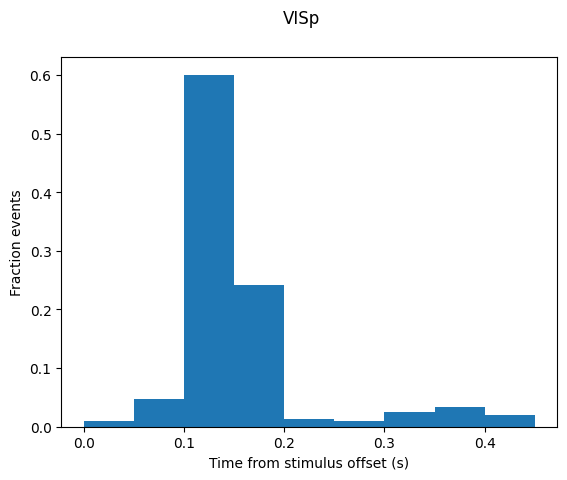

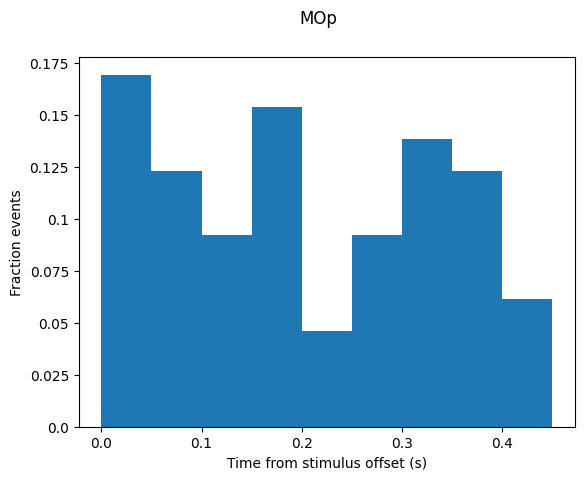

In [22]:
# Plot Histogram of alpha event times relative to stimulus offset
for region in ['VISp', 'MOp']:
    burst_times_relative_to_stim_end = []
    for session_id in sessions:
        session_dir = os.path.join(data_dir, session_id)
        session_areas = glob.glob(os.path.join(session_dir, '*_burst_times.npy'))
        session_burst_areas = np.unique([os.path.basename(f).split('_')[0] for f in session_areas])

        if region in session_burst_areas:
            session_burst_times = np.load(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\derived_table_info\4Hz_bursts\session_analysis',
                                            session_id, f'{region}_burst_times.npy'))
            sess_ccgs = session_data[session_id]['ccgs'][region][region]
            good_traces = get_qualifying_autoccgs(sess_ccgs, 0.1)

            session_stim = master_stim[master_stim['session_id']==int(session_id)].sort_values(by='start_time')
            inds_before_bursts = np.searchsorted(session_stim['start_time'].values, session_burst_times) - 1
            good_inds = (inds_before_bursts<len(session_stim))&(inds_before_bursts>-1)
            session_stims_before_bursts = session_stim.iloc[inds_before_bursts[good_inds]]

            session_stims_before_bursts['burst_time'] = session_burst_times[good_inds]
            burst_tensor_inds = np.arange(len(session_burst_times))[good_inds]
            session_stims_before_bursts['qualifying'] = good_traces[good_inds]
            
            q = session_stims_before_bursts[session_stims_before_bursts['qualifying']]

            burst_times_relative_to_stim_end.append(q['burst_time'] - q['end_time'])
    
    fig, ax = plt.subplots()
    fig.suptitle(region)
    all_diffs = [b for sub in burst_times_relative_to_stim_end for b in sub]
    print(f'{region}: num sessions {len(burst_times_relative_to_stim_end)} num events {len(all_diffs)}')
    ax.hist(all_diffs, bins=np.arange(0, 0.5, 0.05), density=True)
    yticks = ax.get_yticks()
    ax.set_yticklabels(np.round(yticks*0.05, 3))
    ax.set_xlabel('Time from stimulus offset (s)')
    ax.set_ylabel('Fraction events')
    #fig.savefig(f'{region}_events_relative_to_stim_offset_histogram.pdf')


In [23]:
#Get pupil and running data for alpha events and random session times
areas_to_plot = ['VISp', 'MOp']

area_pupil = {a: [] for a in areas_to_plot}
area_running = {a: [] for a in areas_to_plot}
area_pupil_rand = {a: [] for a in areas_to_plot}
area_running_rand = {a: [] for a in areas_to_plot}
for area in areas_to_plot:
    running_triggered = []
    running_triggered_rand = []
    pupil_triggered = []
    pupil_triggered_rand = []
    area_sessions = get_session_data_sessions_for_area(session_data, area)
    for session in area_sessions:

        sess_ccgs = session_data[session]['ccgs'][area][area]
        good_ccgs = get_qualifying_autoccgs(sess_ccgs, 0.1)
        
        pupil = session_data[session]['pupil'][area][0]
        good_pupil = pupil[good_ccgs]

        pupil_rand = session_data[session]['pupil_random'][area][0]
        good_pupil_rand = pupil_rand[good_ccgs]

        pupil_triggered.append(good_pupil)
        pupil_triggered_rand.append(good_pupil_rand)
        
        running = session_data[session]['running'][area][0]
        good_running = running[good_ccgs[:len(running)]]
        
        running_rand = session_data[session]['running_random'][area][0]
        good_running_rand = running_rand[good_ccgs[:len(running_rand)]]
        
        if good_running.size>0:
            good_running = np.array([g for g in good_running])
            good_running_rand = np.array([g for g in good_running_rand])
            running_triggered.append(good_running)
            running_triggered_rand.append(good_running_rand)

    area_pupil[area] = np.array([p for p in pupil_triggered])
    area_running[area] = np.array([r for r in running_triggered])
    area_pupil_rand[area] = np.array([p for p in pupil_triggered_rand])
    area_running_rand[area] = np.array([r for r in running_triggered_rand])

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\2992861059.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  good_running = np.array([g for g in good_running])
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\2992861059.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  good_running_rand = np.array([g for g in good_running_rand])
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\2992861059.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with d

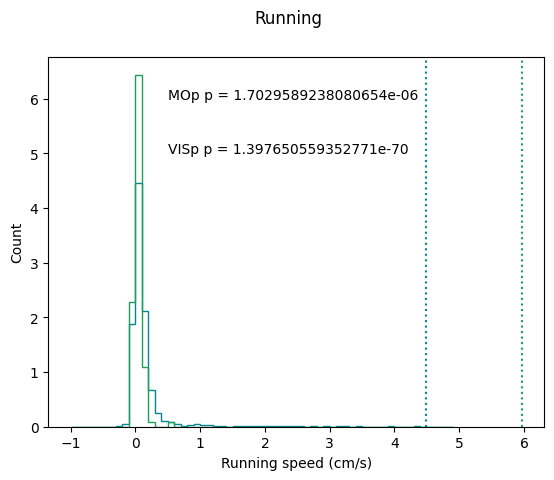

In [26]:
#Plot running speed for alpha vs random session times
colors = {'VISp': ccf_utils.get_area_color('VISp', structure_tree), 'MOp': ccf_utils.get_area_color('MOp', structure_tree)}

fig, ax = plt.subplots()
fig.suptitle('Running')
for ia, area in enumerate(['VISp', 'MOp']):

    running_means = []
    rand_running_means = []
    for running, running_rand in zip(area_running[area], area_running_rand[area]):

        session_running = np.array([p for p in running if p.size>999])
        session_rand_running = np.array([p for p in running_rand if p.size>999])

        if len(session_running)>0:
            peri_burst = np.mean(session_running[:, 500:600], axis=1)
            peri_rand = np.mean(session_rand_running[:, 500:600], axis=1)

            running_means.append(peri_burst)
            rand_running_means.append(peri_rand)

    
    running_flattened = [p for s in running_means for p in s]
    rand_running_flattened = [p for s in rand_running_means for p in s]

    ax.hist(running_flattened, bins=np.arange(-1, 5, 0.1), color=colors[area], density=True, histtype='step')
    #ax.hist(rand_running_flattened, bins=np.arange(-1, 5, 0.1), color='k', alpha=0.5, histtype='step')
    ax.axvline(np.mean(rand_running_flattened), c=colors[area], ls='dotted')
    ax.set_xlabel('Running speed (cm/s)')
    ax.set_ylabel('Count')
    p_val = scipy.stats.ranksums(running_flattened, rand_running_flattened)
    ax.text(0.5,5+ia,f'{area} p = {p_val[1]}')

#fig.savefig(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures\VISp_MOp_running_hist.pdf')

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\3091692760.py:9: RuntimeWarning: Mean of empty slice
  mean_rand = np.nanmean(pupil_rand)
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\3091692760.py:9: RuntimeWarning: Mean of empty slice
  mean_rand = np.nanmean(pupil_rand)


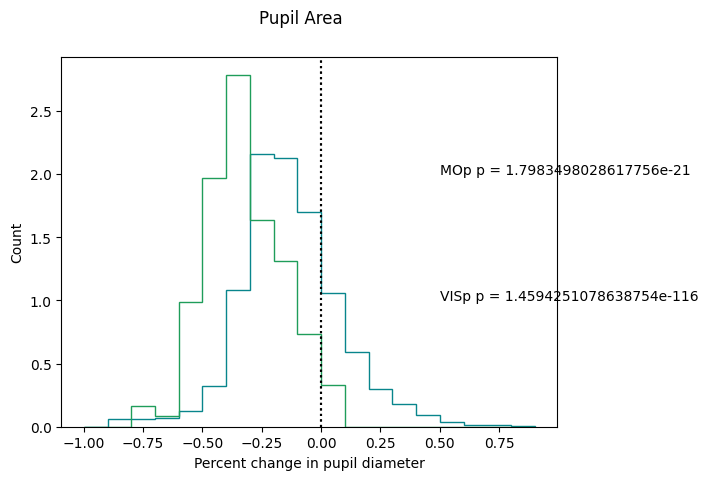

In [27]:
#Plot pupil area for alpha vs random session times
fig, ax = plt.subplots()
fig.suptitle('Pupil Area')
for ia, area in enumerate(['VISp', 'MOp']):

    pupil_diffs = []
    for pupil, pupil_rand in zip(area_pupil[area], area_pupil_rand[area]):

        mean_rand = np.nanmean(pupil_rand)
        session_pupil = np.array([p for p in pupil if p.size>999])

        if len(session_pupil)>0:
            peri_burst = np.mean(session_pupil[:, 500:600], axis=1)
            diff_from_mean = (peri_burst - mean_rand)/mean_rand

            pupil_diffs.append(diff_from_mean)
    
    pupil_diffs_flattened = [p for s in pupil_diffs for p in s]
    ax.hist(pupil_diffs_flattened, bins=np.arange(-1, 1, 0.1), color=colors[area], density=True, histtype='step')
    ax.axvline(0, c='k', ls='dotted')
    ax.set_xlabel('Percent change in pupil diameter')
    ax.set_ylabel('Count')
    p_val = scipy.stats.wilcoxon(pupil_diffs_flattened)
    ax.text(0.5, 1+ia ,f'{area} p = {p_val[1]}')

#fig.savefig(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures\VISp_MOp_pupil_hist.pdf')

In [28]:
#Collect ccgs for area pairs during VISp and MOp alpha events

areas_to_plot = ['VISp', 'MOp']

ccg_dict = {a: {} for a in areas_to_plot}
rand_ccg_dict = {a: {} for a in areas_to_plot}

for area in areas_to_plot:
    area_sessions = get_session_data_sessions_for_area(session_data, area)
    for session in area_sessions:

        sess_ccgs = session_data[session]['ccgs'][area][area]
        good_ccgs = get_qualifying_autoccgs(sess_ccgs, 0.1)
        
        other_areas =  get_areas_recorded_during_session(session)

        for area2 in other_areas:
            ccgs = np.load(os.path.join(data_dir, session, f'{area}_{area2}_ccgs.npy'))
            qualifying = ccgs[good_ccgs]

            rand_ccgs = np.load(os.path.join(data_dir, session, f'{area}_{area2}_ccgs_random.npy'))
            qualifying_rand = rand_ccgs[good_ccgs]

            if not area2 in ccg_dict[area]:
                ccg_dict[area][area2] = []
                rand_ccg_dict[area][area2] = []
           
            ccg_dict[area][area2].append(qualifying)
            rand_ccg_dict[area][area2].append(qualifying_rand)


In [ ]:
areas_to_plot = ['VISp', 'MOp']

time = np.linspace(-1, 1, 200)
for area in areas_to_plot:
    area_ccgs = ccg_dict[area]
    for area2, ccgs in area_ccgs.items():
        fig, axes = plt.subplots(1, 2)
        ax = axes[0]
        fig.suptitle(f'{area} to {area2}')

        rand_ccgs = rand_ccg_dict[area][area2]

        concat = np.concatenate(ccgs)
        rand_concat = np.concatenate(rand_ccgs)

        diff = concat - rand_concat
        diff_mean = np.mean(diff, axis=0)
        diff_std = np.std(diff, axis=0)
        diff_sem =diff_std/diff.shape[0]**0.5

        mean = np.mean(concat, axis=0)
        rand_mean = np.mean(rand_concat, axis=0)

        

        ax.plot(time, mean, 'k')
        ax.plot(time, rand_mean, 'r')

        axes[1].plot(time, diff_mean, 'k')
        axes[1].fill_between(time, diff_mean+diff_sem, diff_mean-diff_sem, color='k', alpha=0.3)

        [a.axvline(0, c='k', ls='dotted') for a in axes]

    

In [29]:
from nitime.analysis import MTCoherenceAnalyzer
from nitime.analysis import CoherenceAnalyzer

import nitime.timeseries as ts

base_sub = lambda x: x - np.mean(x)

def multi_taper_coherence(psths1, psths2, fs=100):
    coh = []
    base_sub = lambda x: x - np.mean(x)

    for p1, p2 in zip(psths1, psths2):
        t = ts.TimeSeries([base_sub(p1), base_sub(p2)], sampling_rate=fs)
        c = MTCoherenceAnalyzer(t)
        coh.append(c.coherence[0,1])
    return c.frequencies, coh

def get_lag_from_coherence(psths1, psths2, fs=100, band=[3,7]):
    coh_delays = []
    for p1, p2 in zip(psths1, psths2):
        t = ts.TimeSeries([base_sub(p1), base_sub(p2)], sampling_rate=fs)
        c = CoherenceAnalyzer(t)
        ind_band_low = np.searchsorted(c.frequencies, 3)
        ind_band_high = np.searchsorted(c.frequencies, 7)

        delays = c.delay[0,1] #positive means first signal leads
        band_delay = np.median(delays[ind_band_low:ind_band_high])
        coh_delays.append(band_delay)
        
    return coh_delays

In [30]:
#Calculate coherence between VISp/MOp and other areas during alpha events and random experiment times

from scipy.signal import coherence
areas_to_plot = ['VISp', 'MOp']

psth_dict = {a: {} for a in areas_to_plot}
rand_psth_dict = {a: {} for a in areas_to_plot}

coherence_dict = {a: {} for a in areas_to_plot}
rand_coherence_dict = {a: {} for a in areas_to_plot}

coherence_delay_dict = {a: {} for a in areas_to_plot}
rand_coherence_delay_dict = {a: {} for a in areas_to_plot}

session_dict = {a: {} for a in areas_to_plot}

for area in areas_to_plot:
    area_sessions = get_session_data_sessions_for_area(session_data, area)
    for session in area_sessions:

        sess_ccgs = session_data[session]['ccgs'][area][area]
        good_ccgs = get_qualifying_autoccgs(sess_ccgs, 0.1)
        
        if np.sum(good_ccgs)>5:
            other_areas =  get_areas_recorded_during_session(session)

            area1_psths = np.load(os.path.join(data_dir, session, f'{area}_{area}_psths.npy'))
            area1_psths = area1_psths[good_ccgs]

            area1_rand_psths = np.load(os.path.join(data_dir, session, f'{area}_{area}_psths_random.npy'))[good_ccgs]
            
            for area2 in other_areas:
                psths = np.load(os.path.join(data_dir, session, f'{area}_{area2}_psths.npy'))
                qualifying = psths[good_ccgs]

                rand_psths = np.load(os.path.join(data_dir, session, f'{area}_{area2}_psths_random.npy'))
                qualifying_rand = rand_psths[good_ccgs]

                if not area2 in psth_dict[area]:
                    psth_dict[area][area2] = []
                    rand_psth_dict[area][area2] = []
                    coherence_dict[area][area2] = []
                    rand_coherence_dict[area][area2] = []
                    session_dict[area][area2] = []
                    coherence_delay_dict[area][area2] = []
                    rand_coherence_delay_dict[area][area2] = []
            
                psth_dict[area][area2].append(qualifying)
                rand_psth_dict[area][area2].append(qualifying_rand)

                freqs, coh = multi_taper_coherence(area1_psths, qualifying, fs=100)
                freqs, rand_coh = multi_taper_coherence(area1_psths, qualifying_rand, fs=100)

                coh_delay = get_lag_from_coherence(area1_psths, qualifying, fs=100, band=[3,7])
                rand_coh_delay = get_lag_from_coherence(area1_rand_psths, qualifying_rand, fs=100, band=[3,7])

                # num_iterations = 100
                # shuffle_rand_coh = []
                # for it in range(num_iterations):
                #     r_p = qualifying_rand[np.random.permutation(qualifying_rand.shape[0])]
                #     freqs, rand_coh = multi_taper_coherence(area1_psths, r_p, fs=100)
                #     shuffle_rand_coh.append(rand_coh)
                
                coherence_dict[area][area2].append(coh)
                rand_coherence_dict[area][area2].append(rand_coh)
                coherence_delay_dict[area][area2].append(coh_delay)
                rand_coherence_delay_dict[area][area2].append(rand_coh_delay)

                session_dict[area][area2].append(session)


c:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\DynamicGating\lib\site-packages\nitime\analysis\coherence.py:200: RuntimeWarning: invalid value encountered in divide
  delay[i, j] = this_phase / (2 * np.pi * self.frequencies)
c:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\DynamicGating\lib\site-packages\nitime\analysis\coherence.py:200: RuntimeWarning: divide by zero encountered in divide
  delay[i, j] = this_phase / (2 * np.pi * self.frequencies)


In [34]:
boxcar = lambda x: np.convolve(x, np.ones(4), 'same')/4

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\3462729681.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1,2)


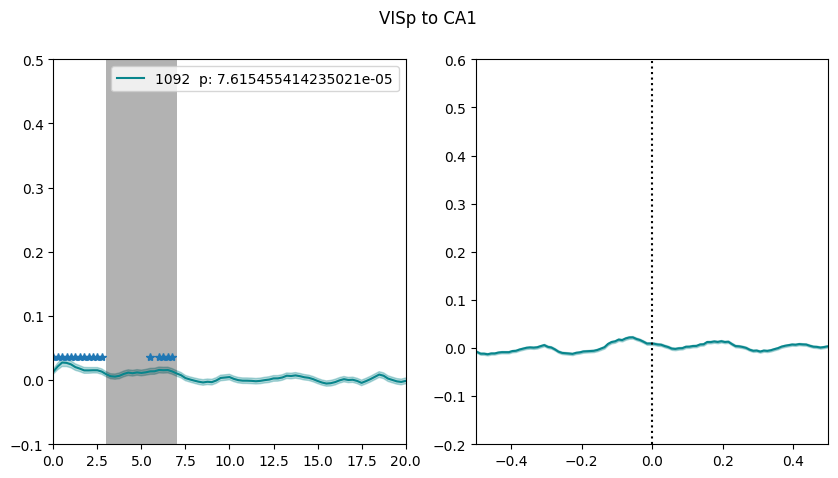

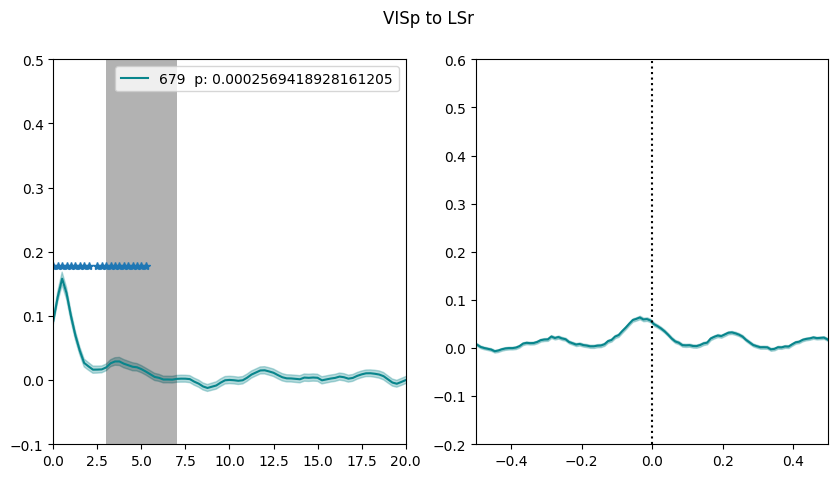

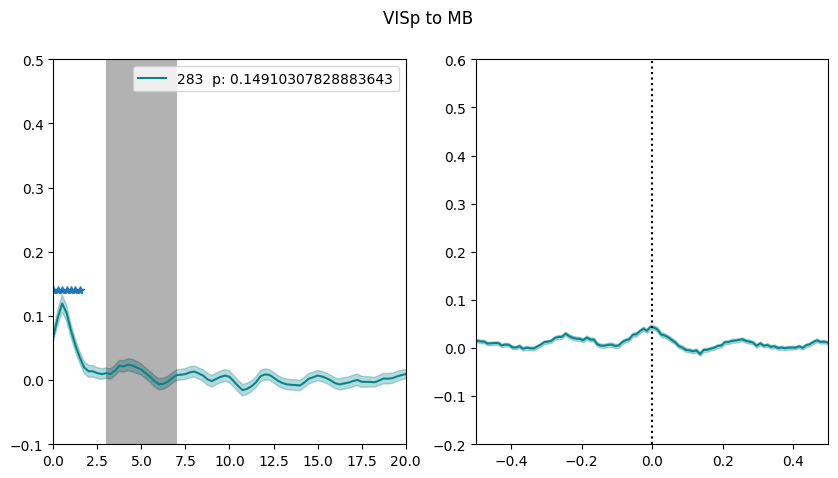

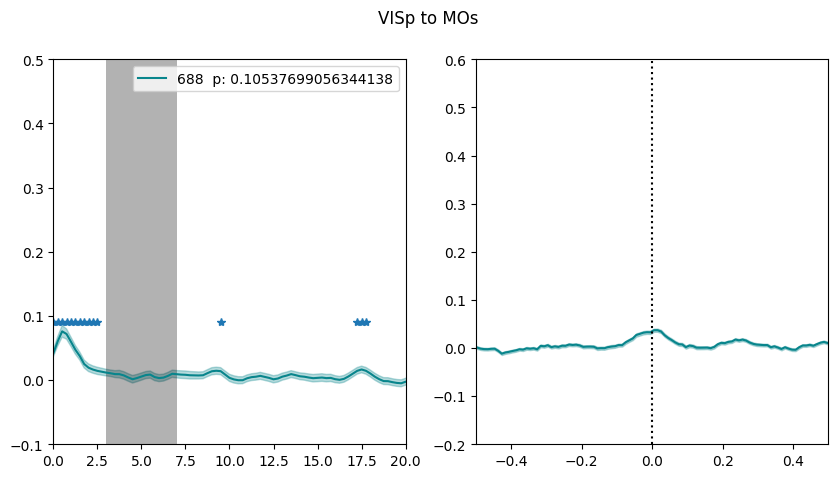

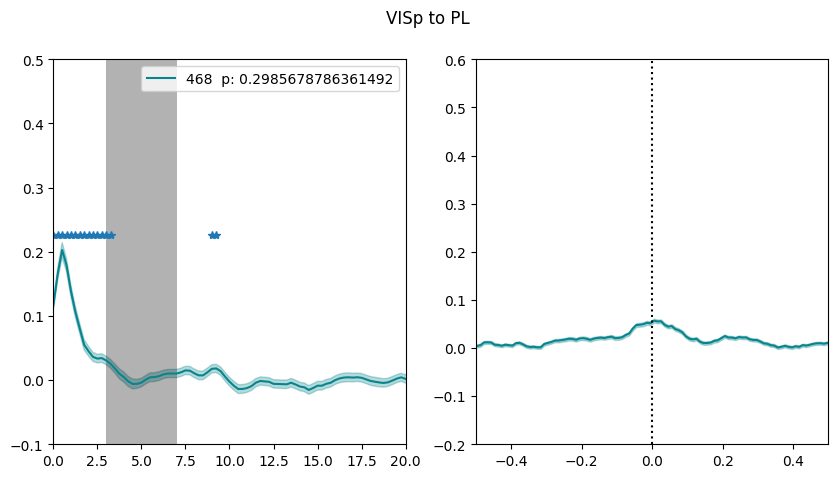

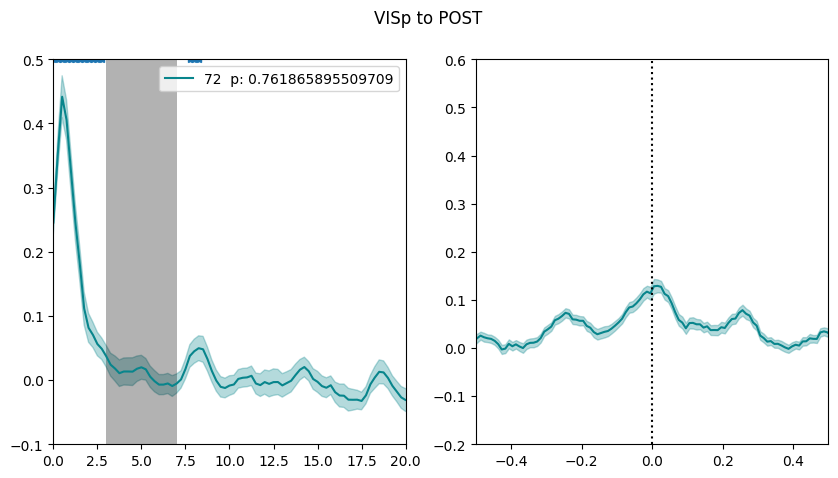

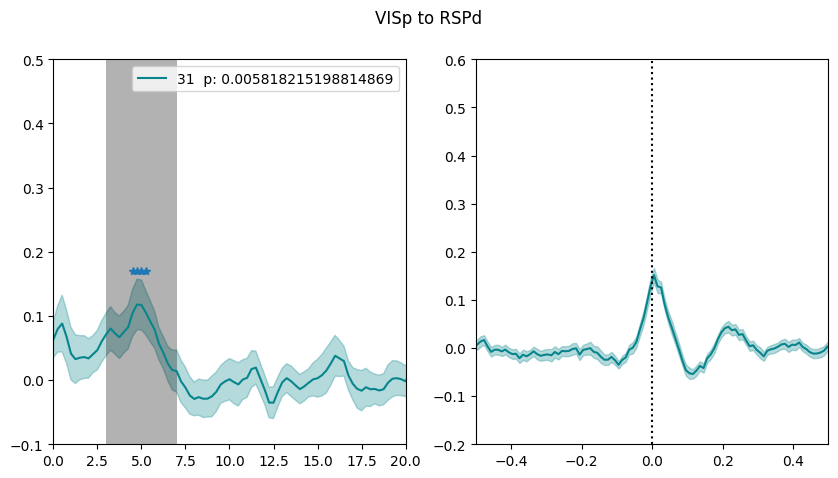

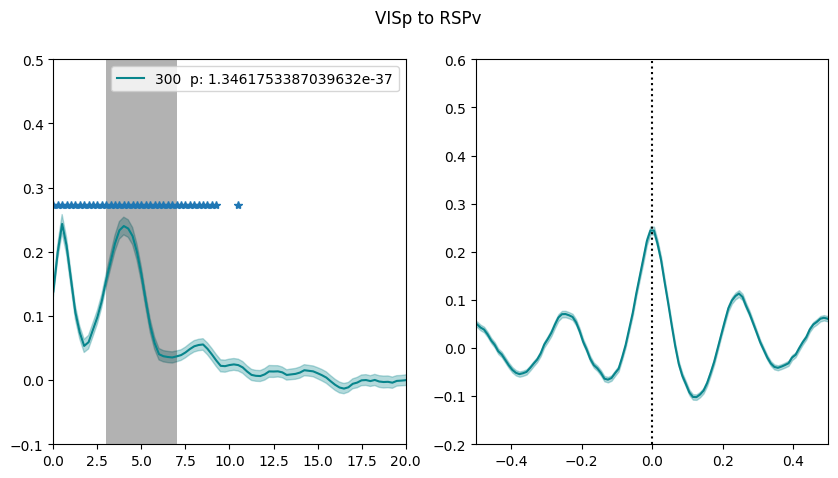

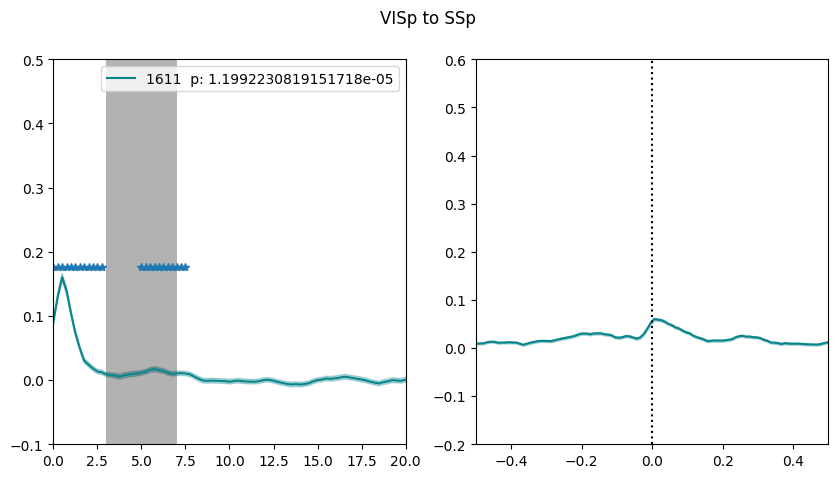

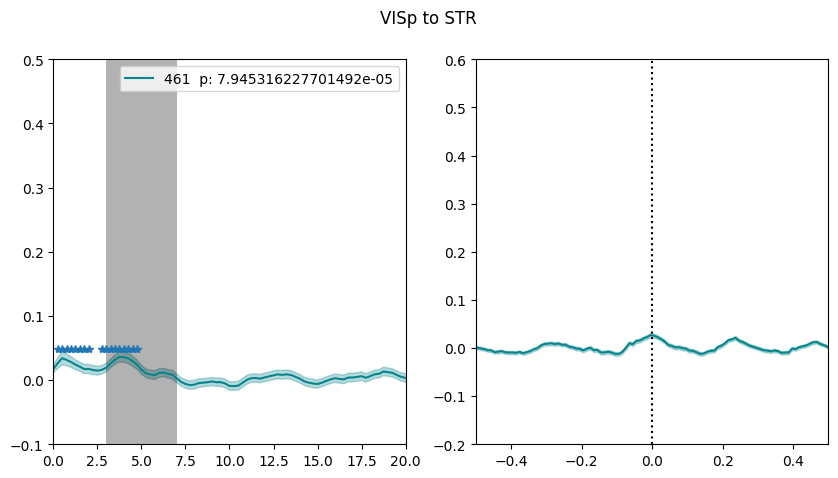

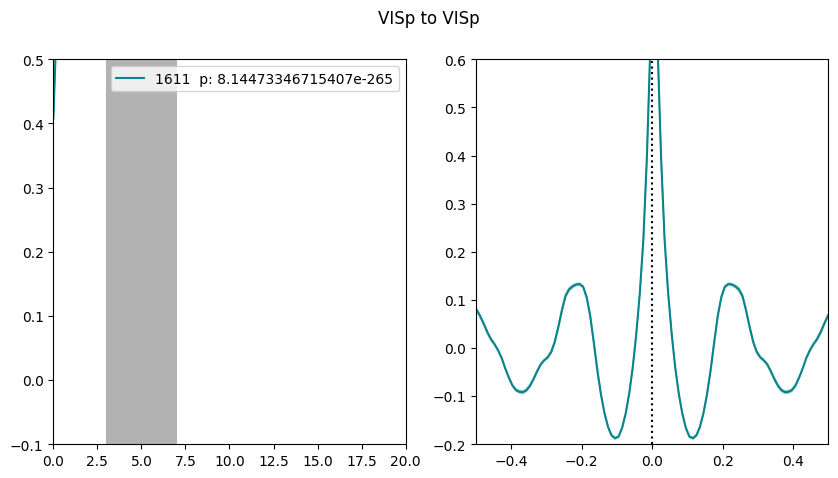

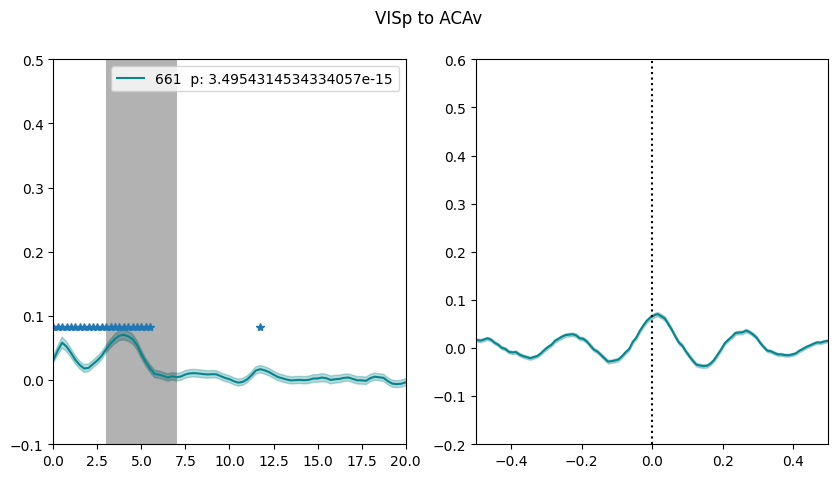

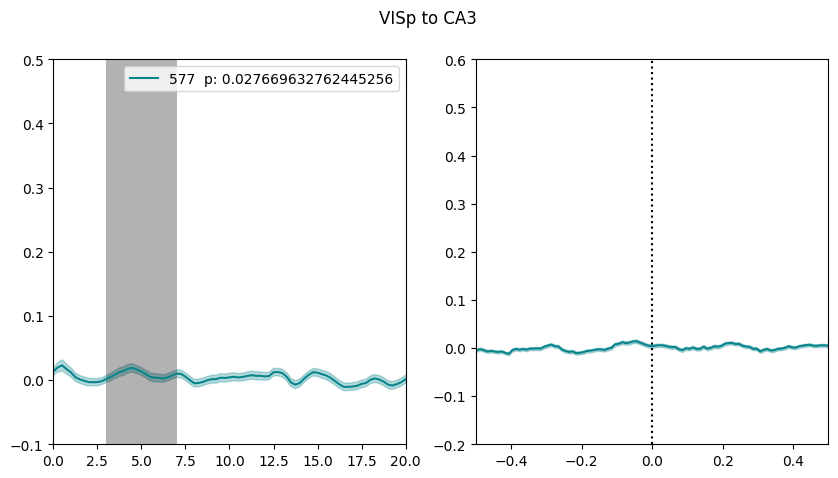

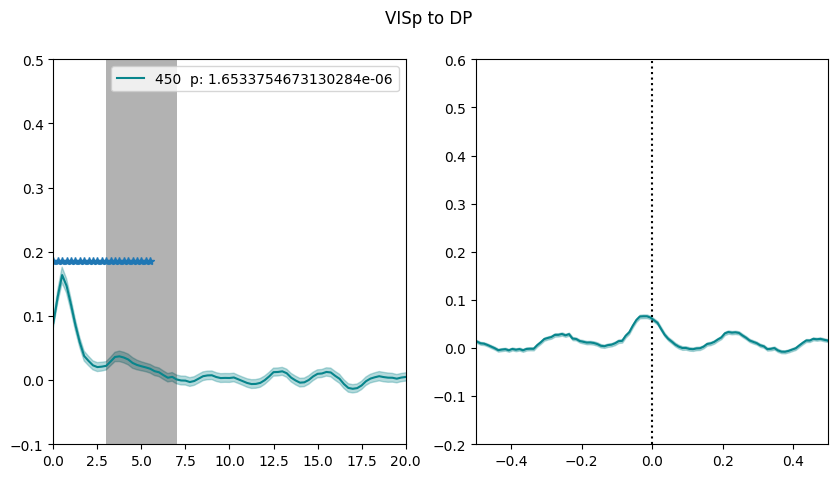

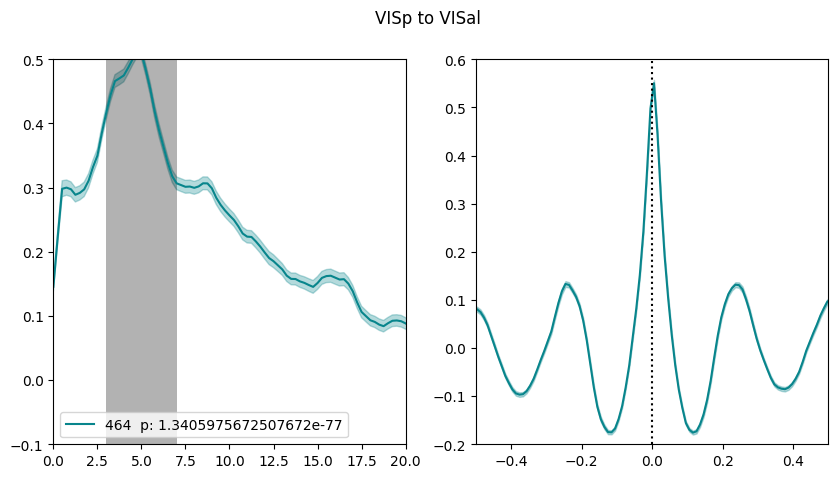

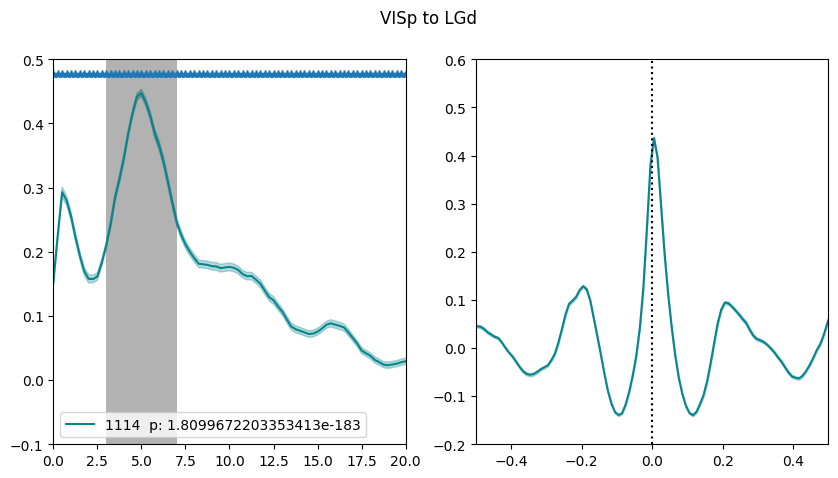

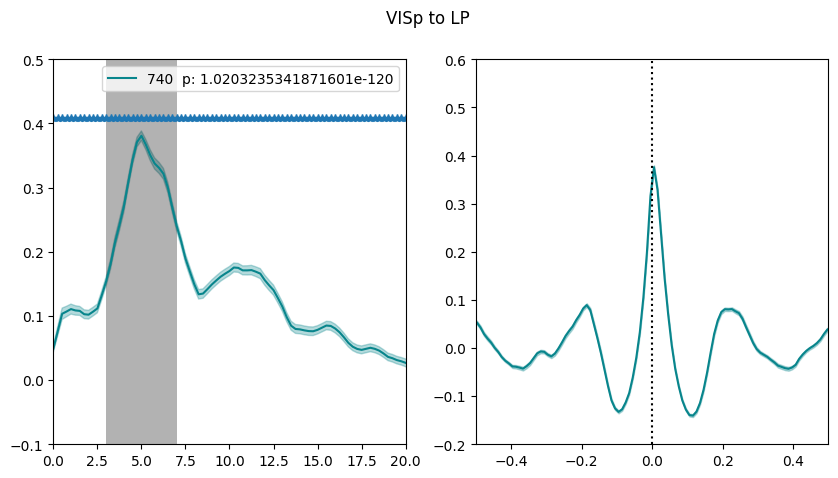

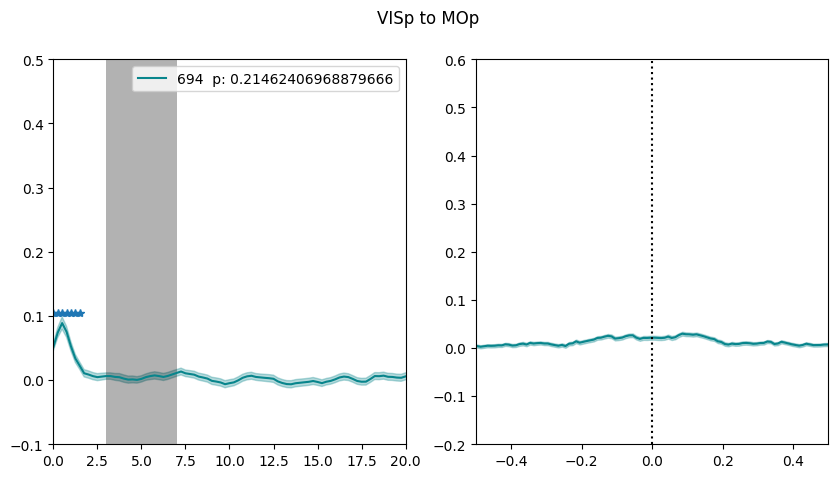

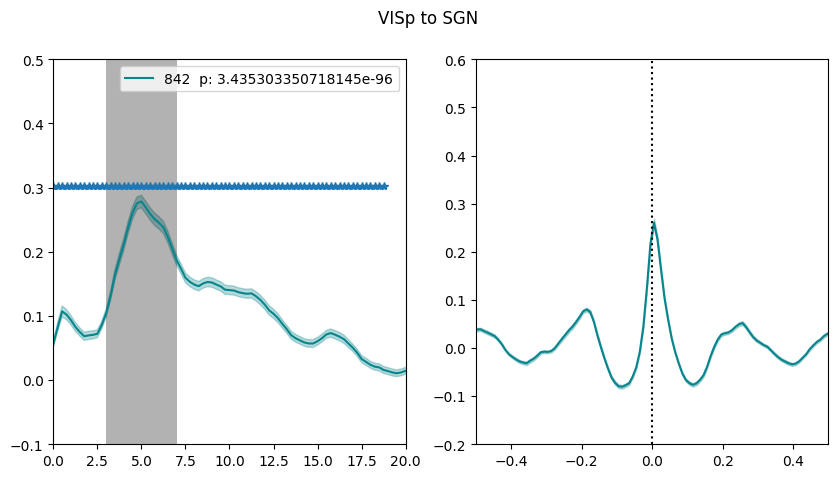

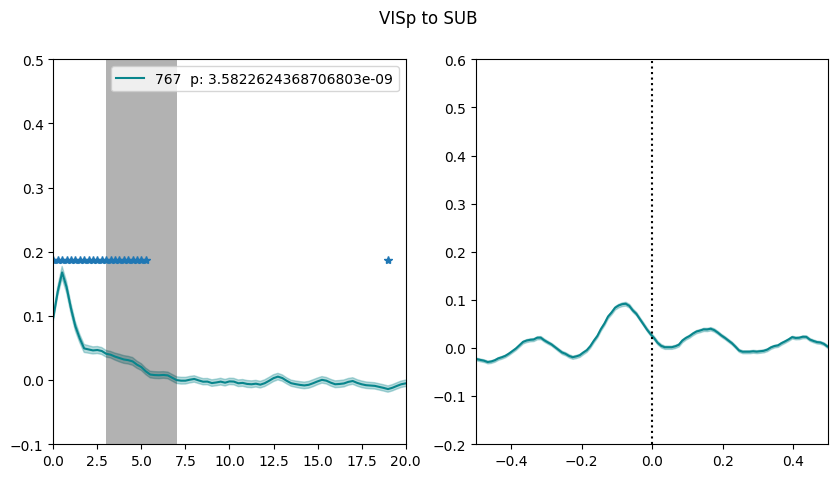

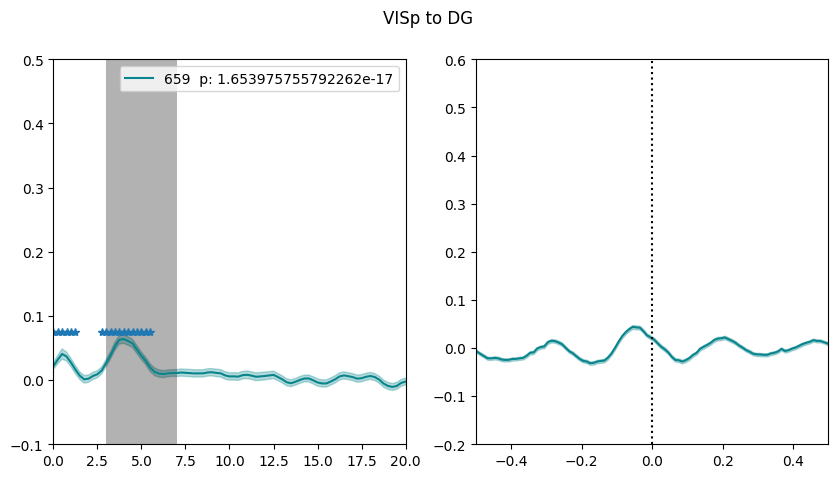

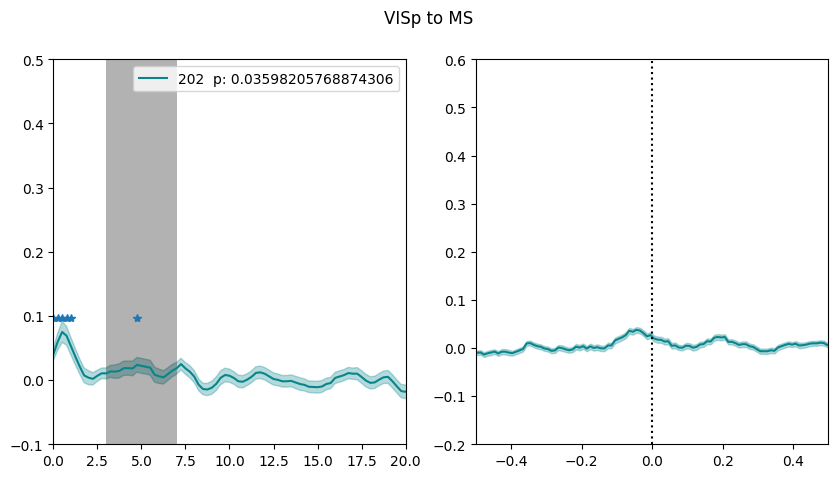

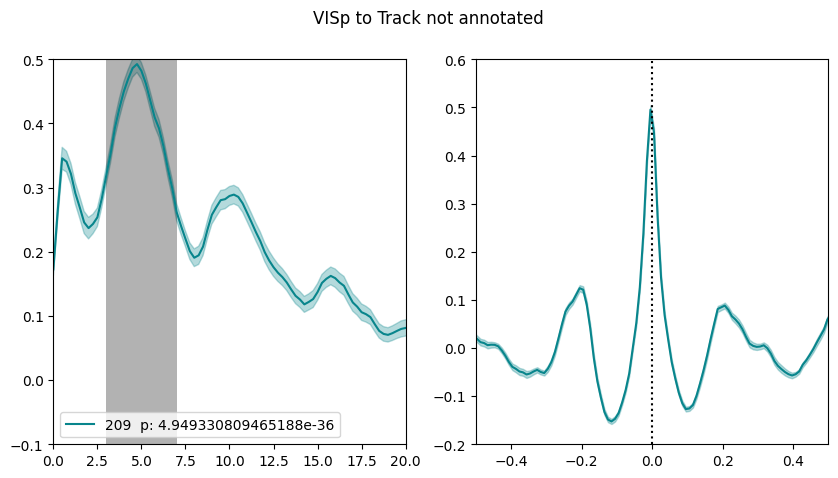

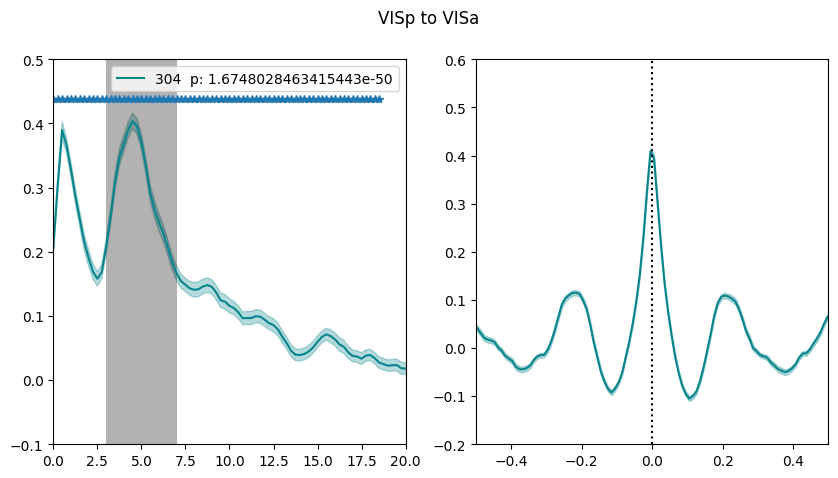

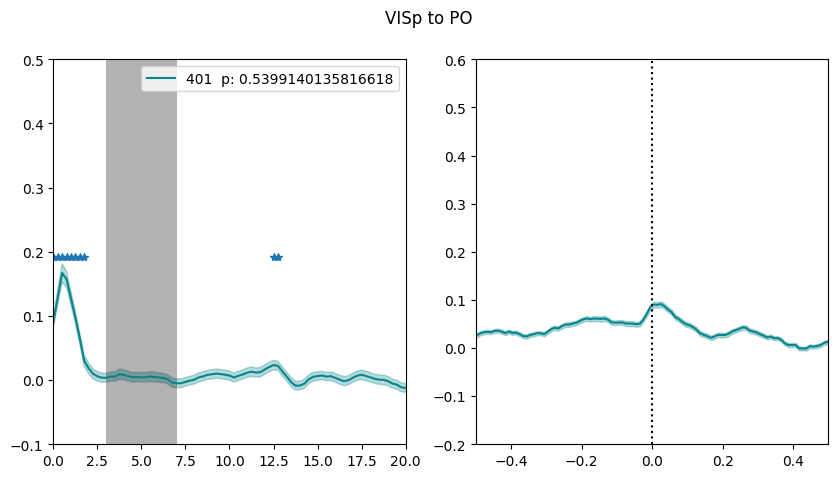

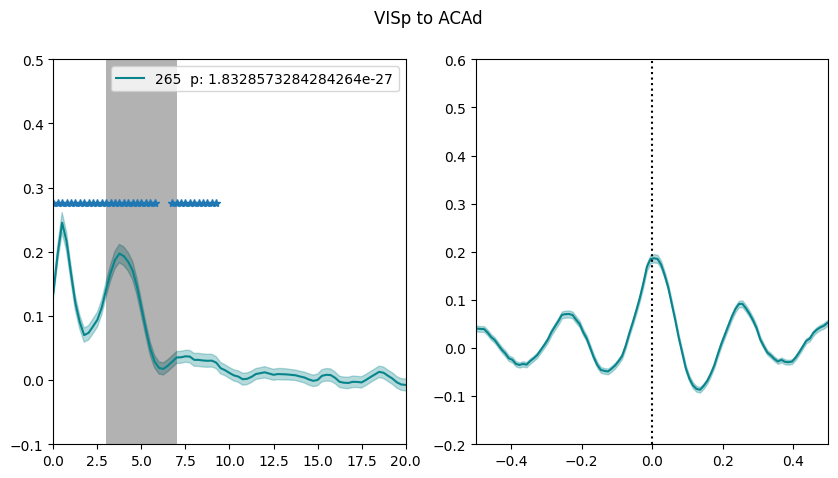

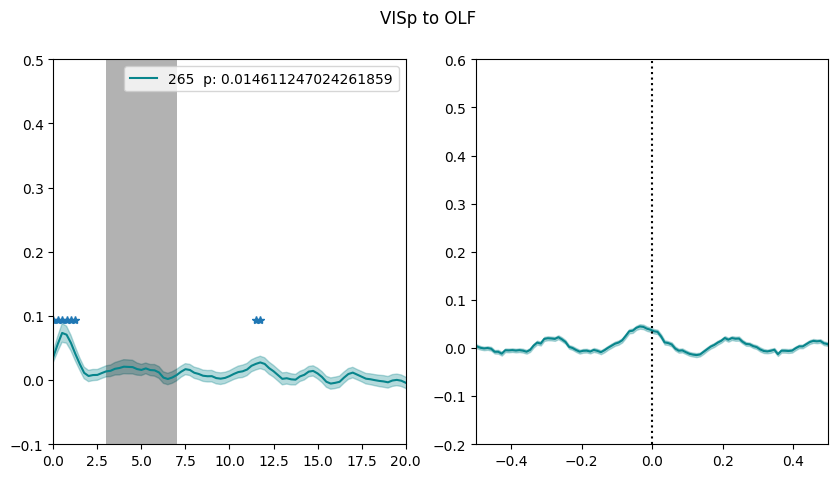

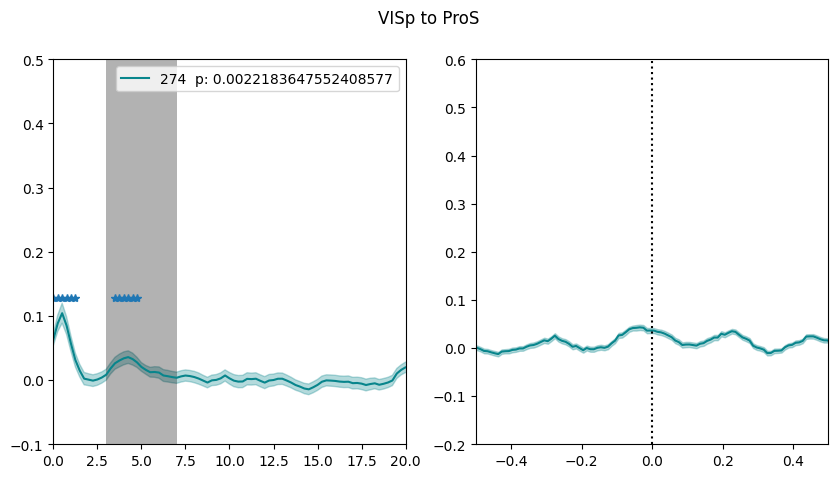

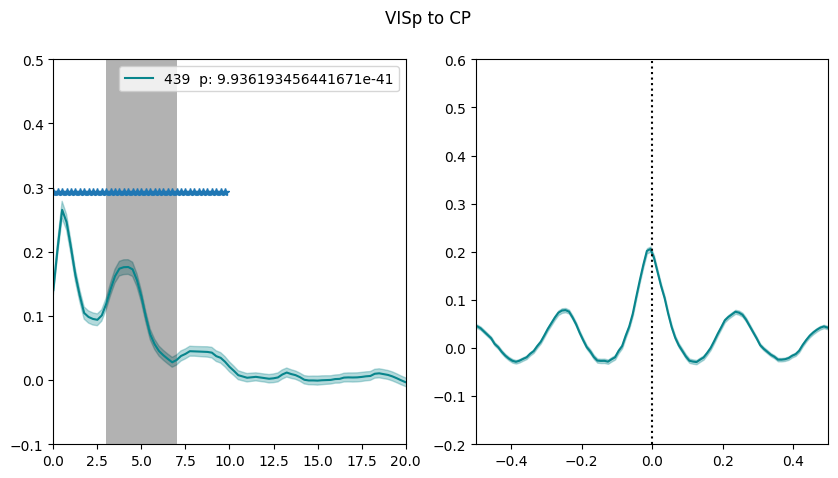

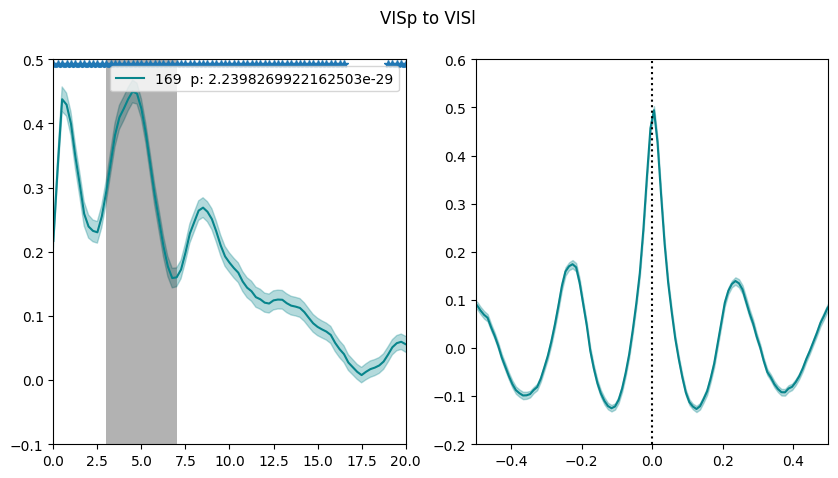

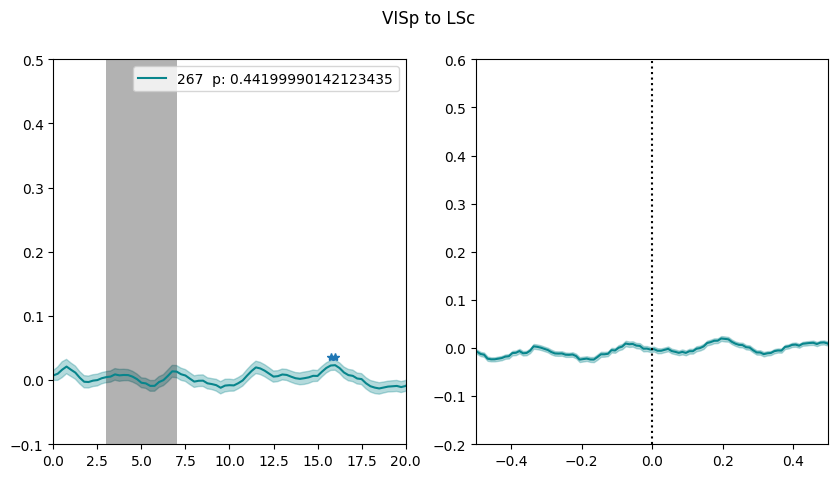

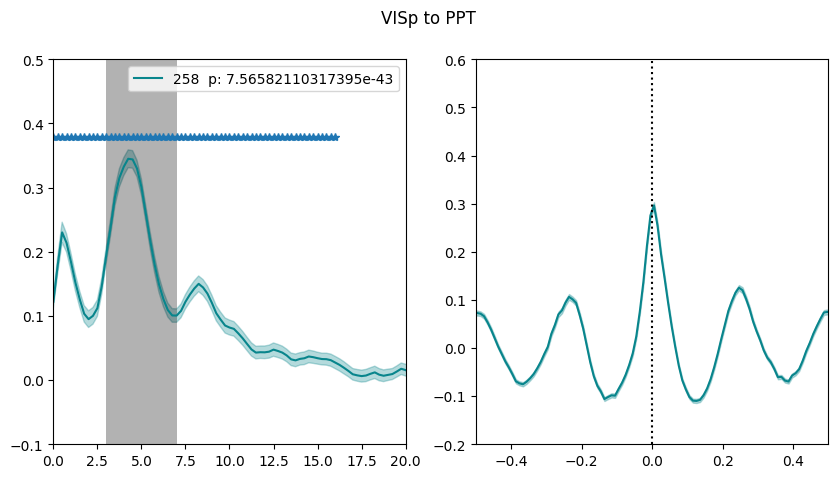

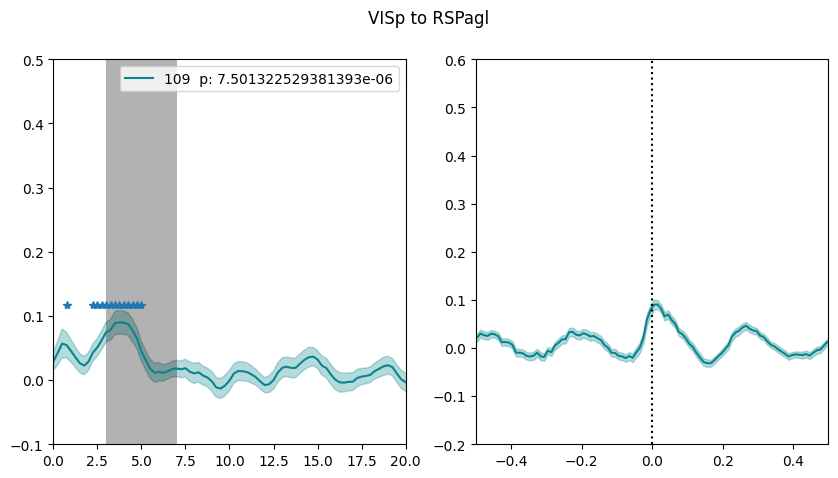

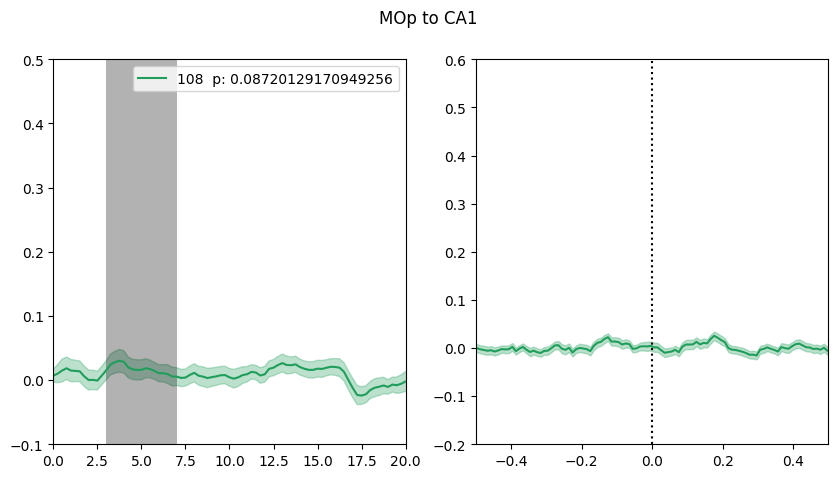

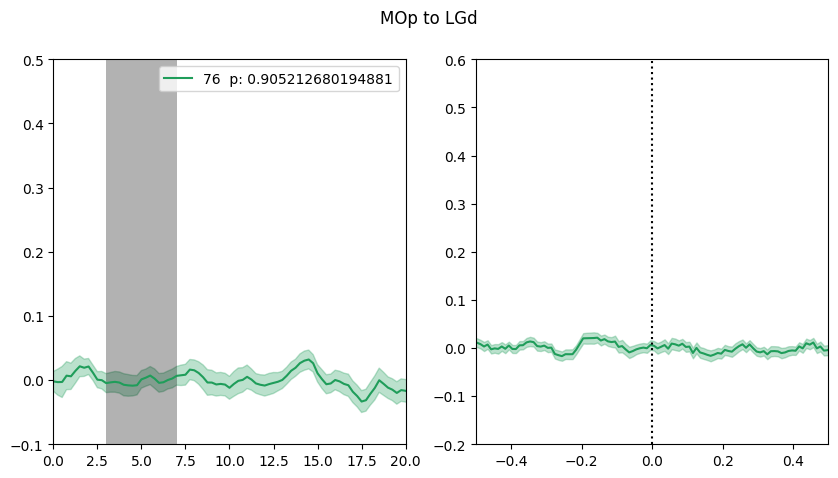

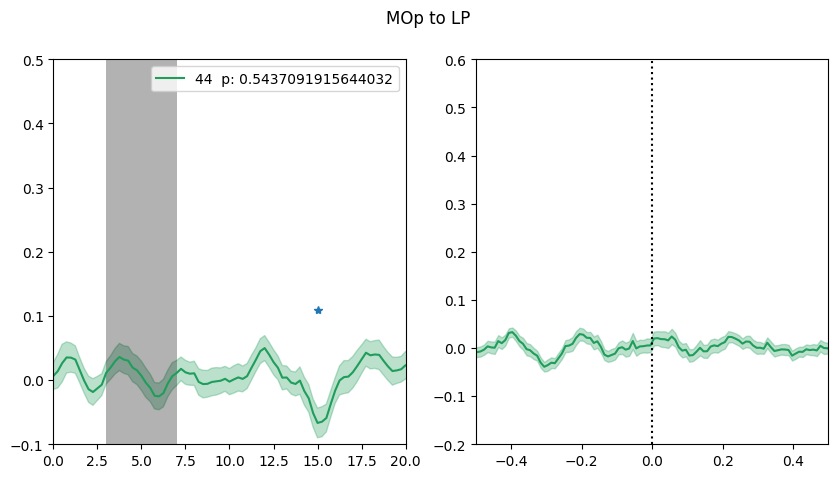

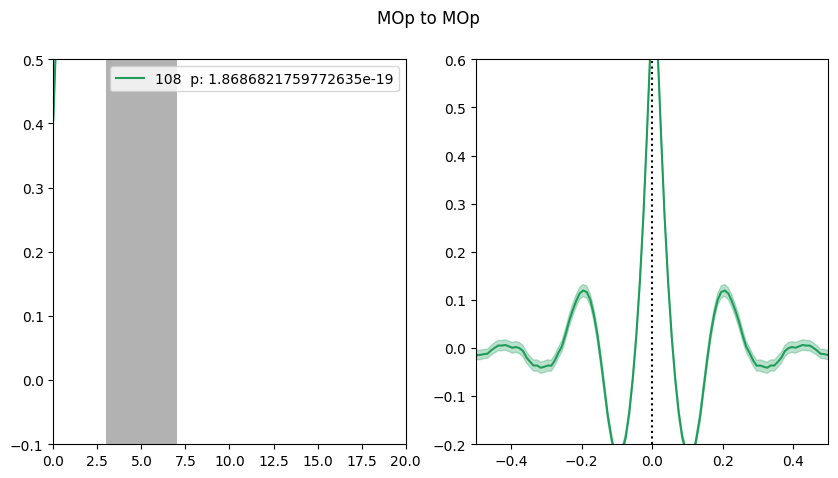

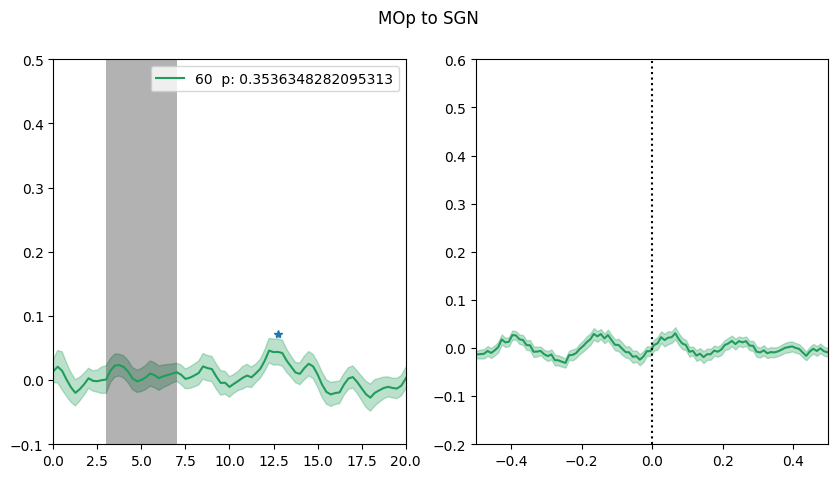

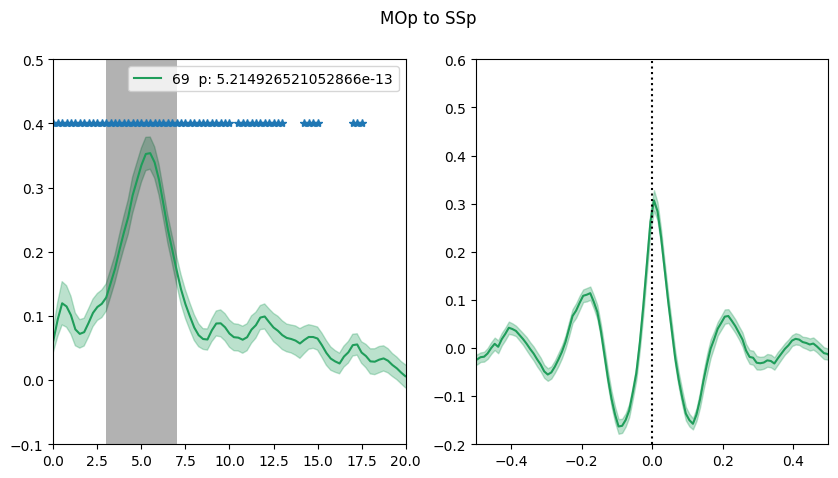

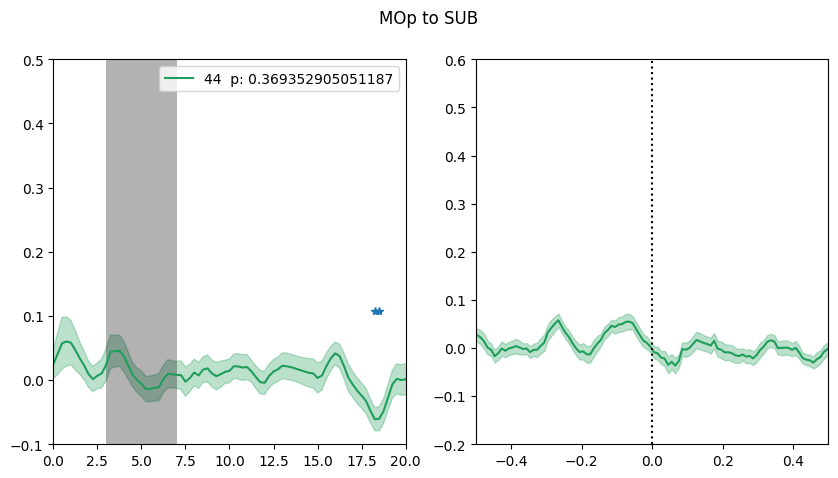

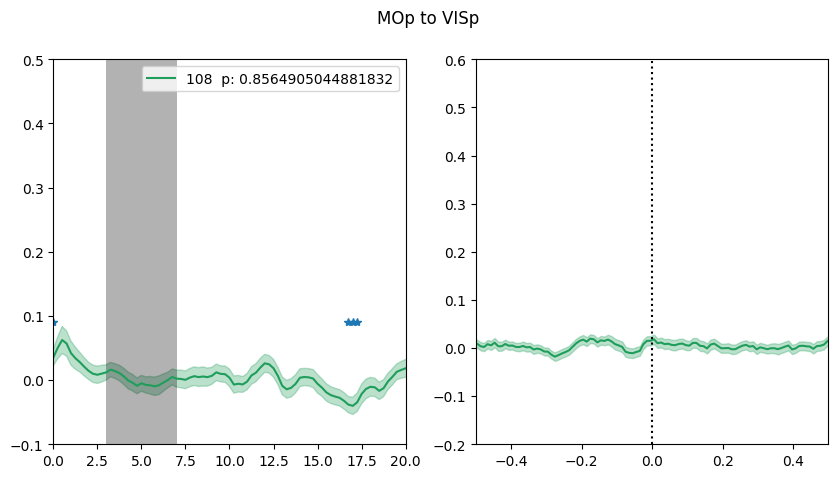

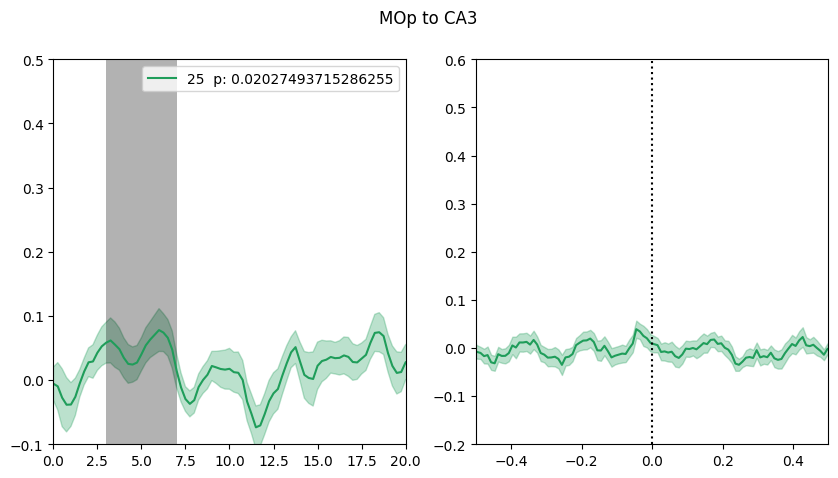

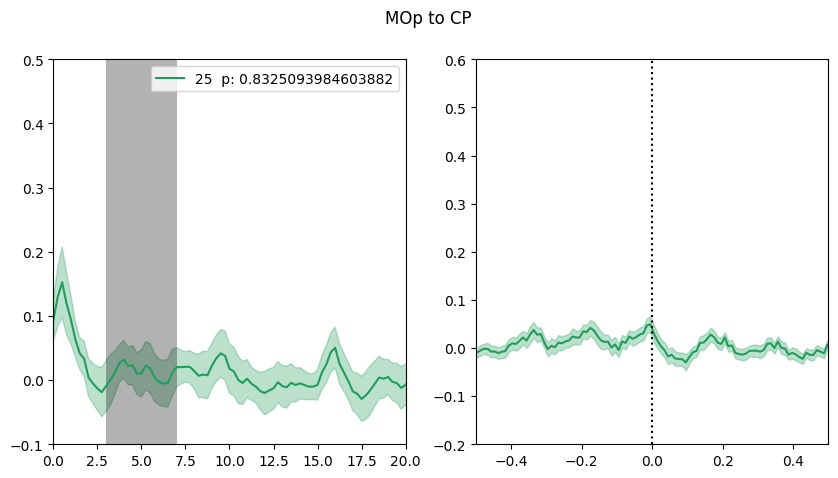

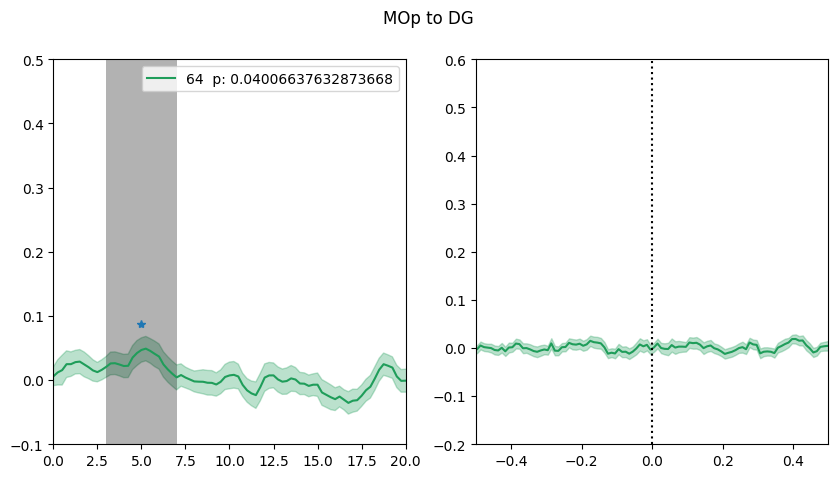

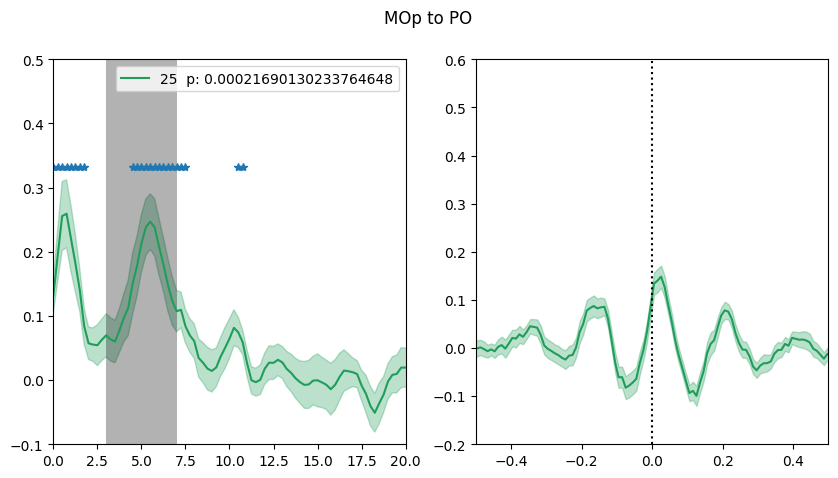

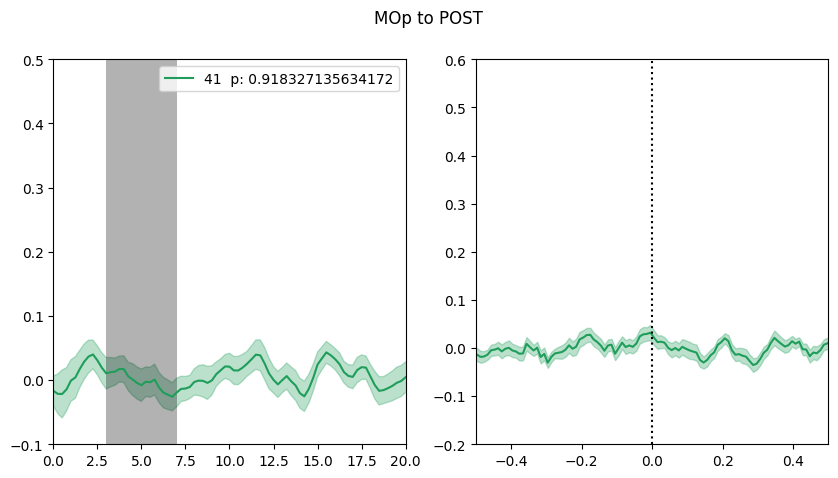

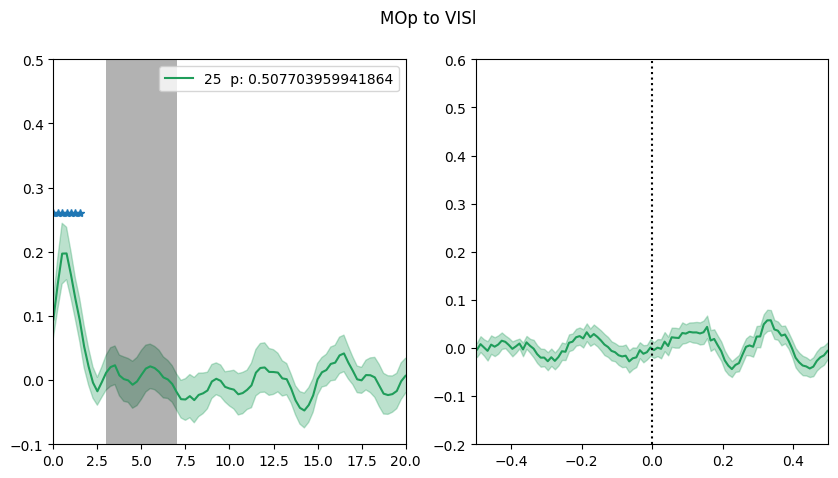

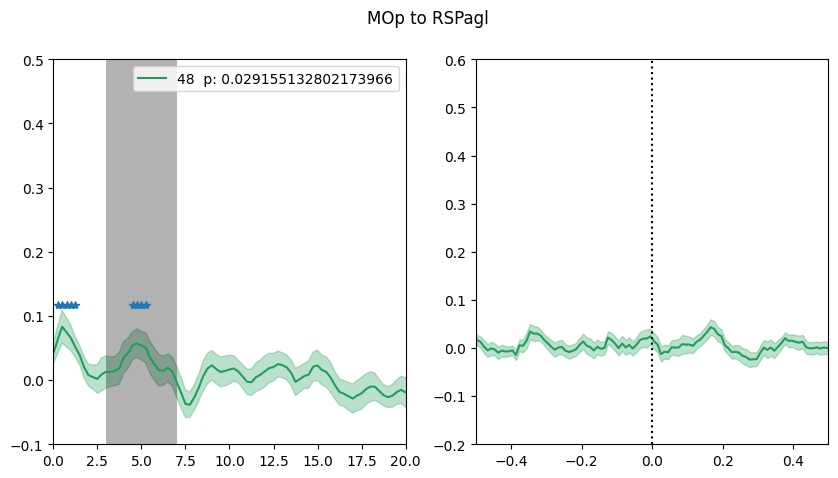

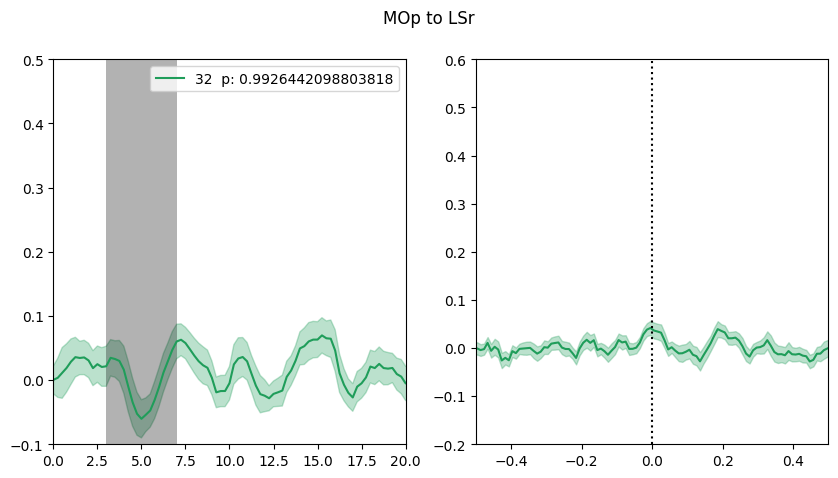

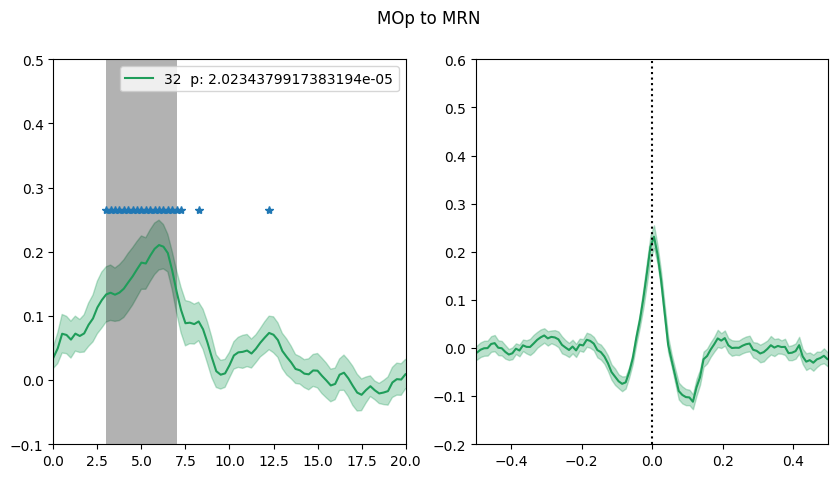

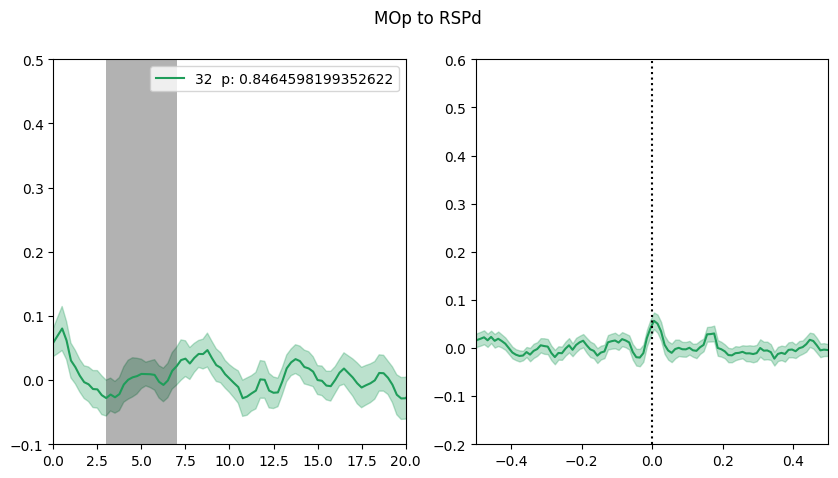

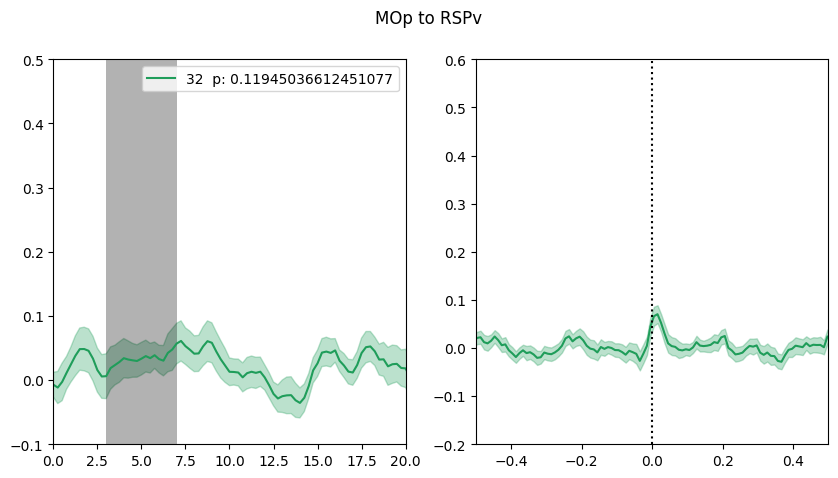

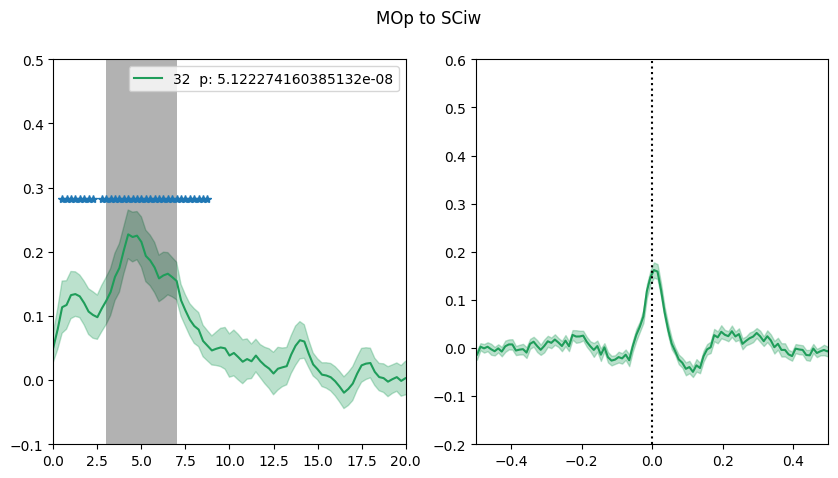

In [35]:
areas_to_plot = ['VISp', 'MOp']
coh_band = {a: {} for a in areas_to_plot}
coh_band_sem = {a: {} for a in areas_to_plot}
coh_sig = {a: {} for a in areas_to_plot}
ind_band_low = np.searchsorted(freqs, 3)
ind_band_high = np.searchsorted(freqs, 7)
time = np.linspace(-1, 1, 200)
for area in areas_to_plot:
    area_coherence = coherence_dict[area]
    area_ccgs = ccg_dict[area]
    for area2, coh in area_coherence.items():
        color = colors[area]
        #coh = np.array([np.mean(c, axis=0) for c in coh if len(c)>5])
        coh = np.concatenate(coh)
        coh = np.array([boxcar(c) for c in coh])

        if coh.shape[0]<25:
            continue
        
        session_coh = [np.mean(c, axis=0) for c in area_coherence[area2]]


        ccgs = ccg_dict[area][area2]
        ccgs = np.concatenate(ccgs)

        fig, axes = plt.subplots(1,2)
        fig.set_size_inches([10, 5])
        #diff_and_mean_ax = axes[0]
        diff_ax = axes[0]
        ccg_ax = axes[1]
        fig.suptitle(f'{area} to {area2}')

        #coh = np.concatenate(coh)
        #rand_coh = np.concatenate([np.mean(rc, axis=0) for rc in rand_coherence_dict[area][area2]])
        #rand_coh = np.array([np.mean(c, axis=0) for c in rand_coherence_dict[area][area2] if len(c)>5])
        rand_coh = np.concatenate(rand_coherence_dict[area][area2])
        rand_coh = np.array([boxcar(c) for c in rand_coh])

        session_rand_coh = [np.mean(c, axis=0) for c in rand_coherence_dict[area][area2]]

        coh_diff = coh - rand_coh
        pvals = np.array([scipy.stats.wilcoxon(c)[1] for c in coh_diff.T])
        sig_freqs = pvals<0.01
        sig_plot = np.ones(len(sig_freqs))
        sig_plot[~sig_freqs] = np.nan

        mean_coh_diff = np.mean(coh_diff, axis=0)
        sem_coh_diff = np.std(coh_diff, axis=0)/(coh.shape[0])**0.5

        mean_coh = np.mean(coh, axis=0)
        sem_coh = np.std(coh, axis=0)/(coh.shape[0])**0.5
        mean_rand_coh = np.mean(rand_coh, axis=0)
        sem_rand_coh = np.std(rand_coh, axis=0)/(rand_coh.shape[0])**0.5

        mean_in_band_per_trial = np.mean(coh_diff[:, ind_band_low:ind_band_high], axis=1)
        coh_band[area][area2] = np.mean(mean_coh_diff[ind_band_low:ind_band_high])
        coh_band_sem[area][area2] = np.std(mean_in_band_per_trial)/(len(mean_in_band_per_trial)**0.5)
        coh_sig[area][area2] = scipy.stats.wilcoxon(np.mean(coh_diff[:, ind_band_low:ind_band_high], axis=1))[1]

        # ax.plot(freqs, mean_coh, color)
        # ax.fill_between(freqs, mean_coh + sem_coh, mean_coh - sem_coh, color = color, alpha=0.3)
        # ax.plot(freqs, mean_rand_coh, 'r')
        # ax.fill_between(freqs, mean_rand_coh + sem_rand_coh, mean_rand_coh - sem_rand_coh, color = 'r', alpha=0.3)


        # for s_c in session_coh:
        #     ax.plot(freqs, s_c)

        #ax.legend(['mean'] + session_dict[area][area2])
        
        diff_ax.plot(freqs, mean_coh_diff, color)
        diff_ax.fill_between(freqs, mean_coh_diff+sem_coh_diff, mean_coh_diff-sem_coh_diff, color=color, alpha=0.3)
        ymax = diff_ax.get_ylim()[1]
        diff_ax.plot(freqs, sig_plot*ymax, '*')

        [a.set_xlim([0, 20]) for a in [diff_ax]]
        [a.set_ylim([-0.1, 0.5]) for a in [diff_ax]]

        [a.axvspan(3,7, facecolor='k', alpha=0.3) for a in [diff_ax]]

        legend_str = f'{coh.shape[0]}  p: {coh_sig[area][area2]}'
        diff_ax.legend([legend_str])
        

        mean_ccg = np.mean(ccgs, axis=0)
        sem_ccg = np.std(ccgs, axis=0)/(ccgs.shape[0])**0.5
        ccg_ax.plot(time, np.mean(ccgs, axis=0), color)
        ccg_ax.fill_between(time, mean_ccg+sem_ccg, mean_ccg-sem_ccg, alpha=0.3, color=color)
        ccg_ax.axvline(0, color='k', ls='dotted')
        ccg_ax.set_xlim([-0.5, 0.5])
        ccg_ax.set_ylim([-0.2, 0.6])

        # fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures\coherence_plots',
        #                         f'{area}_to_{area2}_coherence.pdf'))

In [43]:
from statsmodels.stats.multitest import fdrcorrection

In [44]:
coh_sig_corrected = {a: {} for a in areas_to_plot}

for area in ['VISp', 'MOp']:
    pvals = []
    for area2, pval in coh_sig[area].items():
        pvals.append(pval)
    
    corrected_pvals = fdrcorrection(pvals)
    for ind, (area2, pval) in enumerate(coh_sig[area].items()):
        coh_sig_corrected[area][area2] = corrected_pvals[0][ind]

In [45]:
other_areas = list(coh_band['VISp'].keys()) + list(coh_band['MOp'].keys())
other_areas = np.unique(other_areas)
other_areas = np.array([o for o in other_areas if 'Track' not in o])
other_areas = np.sort(other_areas)
other_area_brain_divisions = [ccf_utils.get_brain_division_for_area(o, structure_tree) for o in other_areas]

brain_division_order = {
    'Isocortex': 1,
    'Hippocampal formation': 2,
    'Thalamus': 3,
    'Striatum': 4,
    'Pallidum': 5,
    'Midbrain': 6,
    'Olfactory areas': 7,
    'not in list': 8
}

other_area_brain_division_order = [brain_division_order[o] for o in other_area_brain_divisions]

area_df = pd.DataFrame({'area': other_areas, 'brain_division': other_area_brain_divisions, 'order': other_area_brain_division_order})
other_areas = area_df.sort_values(by=['order', 'area'])['area'].values


Text(0.5, 0, 'CCF Region')

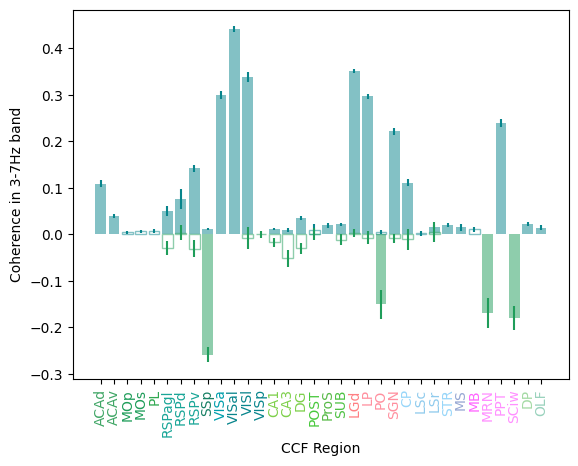

In [46]:
fig, ax = plt.subplots()
multiplier = {'VISp': 1, 'MOp': -1}
for area in areas_to_plot:
    area_coh = []
    area_coh_sem = []
    area_coh_sig = []
    for area2 in other_areas:

        c = coh_band[area].get(area2, np.nan)
        sig = coh_sig_corrected[area].get(area2, np.nan)
        sem = coh_band_sem[area].get(area2, np.nan)
        if area==area2:
            c = np.nan
            sig= np.nan
            sem = np.nan
        area_coh.append(c)
        area_coh_sig.append(sig)
        area_coh_sem.append(sem)

    area_coh = np.array(area_coh)
    bars = ax.bar(np.arange(len(other_areas)), multiplier[area]*area_coh, 
                            alpha=0.5, color=colors[area], yerr=area_coh_sem,
                            error_kw=dict(ecolor=colors[area]))
    for ib, bar in enumerate(bars):
        sig = area_coh_sig[ib]
        if ~np.isnan(sig) and not sig:
            bar.set_color('w')
            bar.set_edgecolor(colors[area])
        

ax.set_xticks(np.arange(len(other_areas)))
ax.set_xticklabels(other_areas, rotation=90)
tick_colors = [ccf_utils.get_area_color(o, structure_tree) for o in other_areas]
for xtick, tick_color in zip(ax.get_xticklabels(), tick_colors):
    xtick.set_color(tick_color)

ax.set_ylabel('Coherence in 3-7Hz band')
ax.set_xlabel('CCF Region')
#fig.savefig(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures\VISp_MOp_coherence_bar_plots.pdf')

VISp to VISal lag: 1.5882775578075972e-16
VISp to VISl lag: 0.00012760237119076117
VISp to LGd lag: 2.415347387718132e-49
VISp to LP lag: 0.010325402857717356
VISp to CP lag: 3.0077715447254523e-24
MOp to SSp lag: 0.0023634714579872317
MOp to PO lag: 0.00021690130233764648


C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\60446723.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  area_delays = np.array(area_delays)[corrected_pvals]


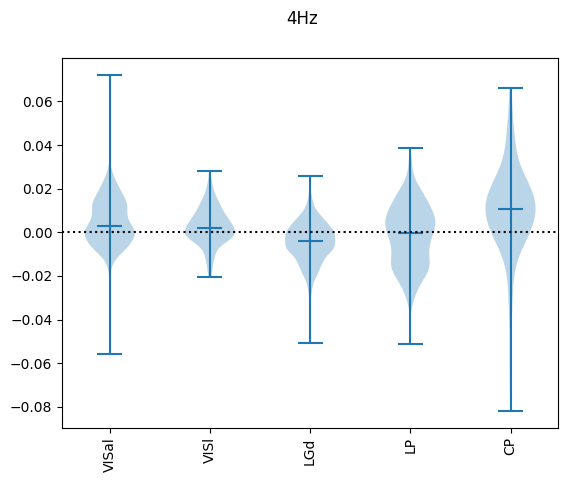

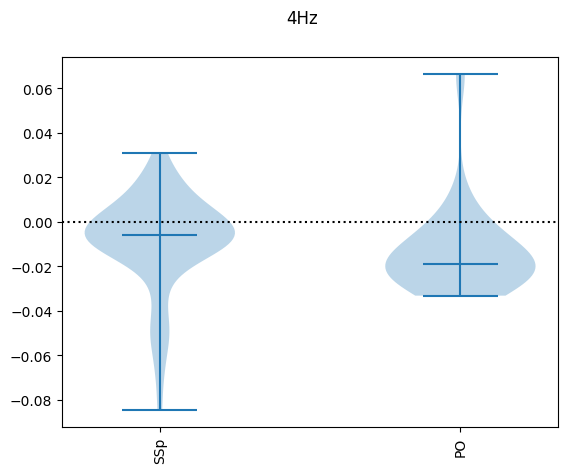

In [48]:
areas_to_plot_for_lag = {'VISp': ['VISl', 'VISal', 'LGd', 'LP', 'CP'], 'MOp': ['SSp', 'PO']}
for area in areas_to_plot:
    for delay_dict, label in zip([coherence_delay_dict], ['4Hz']):
        delay_data = delay_dict[area]
        fig, ax = plt.subplots()
        fig.suptitle(label)
        area_delays = []
        area_delay_names = []
        area_delay_pvals = []
        for area2 in other_areas:
            if area2 in delay_data and not area==area2 and area2 in areas_to_plot_for_lag[area]:
                delays = delay_data[area2]
        # for area2, delays in delay_data.items():
                if area2 in coh_sig_corrected[area] and coh_sig_corrected[area][area2]:
                    delays_flattened = [v for s in delays for v in s]
                    area_delays.append(delays_flattened)
                    area_delay_names.append(area2)
                    print(f'{area} to {area2} lag: {scipy.stats.wilcoxon(delays_flattened)[1]}')
                    area_delay_pvals.append(scipy.stats.wilcoxon(delays_flattened)[1])

        corrected_pvals = fdrcorrection(area_delay_pvals)[0]
        area_delays = np.array(area_delays)[corrected_pvals]
        area_delay_names = np.array(area_delay_names)[corrected_pvals]
        
        ax.violinplot(area_delays, showmedians=True)
        ax.axhline(0, color='k', ls='dotted')
        ax.set_xticks(np.arange(1, len(area_delays)+1))
        ax.set_xticklabels(area_delay_names, rotation=90)
        #ax.set_ylim(-0.05, 0.05)

        #fig.savefig(f'{area}_{label}_lags.pdf')

CP RF and no RF analysis

In [73]:
import h5py
import tensor_utils as tu

In [74]:
task_tensor = h5py.File(r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\dg_active_unit_tensor.hdf5")
burst_tensor = h5py.File(r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\dg_active_unit_tensor_VISp_bursts.hdf5")


In [75]:
from analysis_utils import exponential_convolve

In [76]:
def determine_visually_responsive(unit_response_mean, vis_response_slice=slice(25, 35), baseline_slice=slice(15, 25)):

    baseline_mean = np.mean(unit_response_mean[baseline_slice], axis=0)
    baseline_std = np.std(unit_response_mean[baseline_slice])
    response_mean = np.mean(unit_response_mean[vis_response_slice])

    # print(baseline_mean, baseline_std, (baseline_std*2 + baseline_mean), response_mean)
    return response_mean > (baseline_std*2 + baseline_mean)

def determine_visually_responsive_array(unit_response_array, vis_response_slice=slice(27, 37), baseline_slice=slice(15, 25)):

    baseline_means = np.mean(unit_response_array[:, baseline_slice], axis=1)
    response_means = np.mean(unit_response_array[:, vis_response_slice], axis=1)

    pval = scipy.stats.kstest(baseline_means, response_means)
    return pval[1]<0.05 and np.mean(response_means)>np.mean(baseline_means)    

In [77]:
def exponential_convolve_array(array, tau=2):
    newarray = np.zeros_like(array)
    for ic, cell in enumerate(array):
        for it, trial in enumerate(cell):
            trial = exponential_convolve(trial, tau)
            newarray[ic, it] = trial
    
    return newarray

In [78]:
def get_image_response(unit_ids, session_task_tensor):

    area_sess_stim_tensor = tu.get_tensor_by_unit_ids(unit_ids, 
                                                        session_task_tensor)

    area_sess_stim_tensor_base_sub = area_sess_stim_tensor - np.mean(area_sess_stim_tensor[:, :, 200:250])
    area_sess_stim_tensor_base_sub_smooth = exponential_convolve_array(area_sess_stim_tensor_base_sub)

    return area_sess_stim_tensor_base_sub_smooth

In [ ]:
cp_rf = []
cp_no_rf = []
v1 = []
for session_id in ['1182628226', '1182871514', '1183071525', '1194850630', '1195036753']:

    session_task_tensor = task_tensor[session_id]
    session_units = tu.apply_good_units_filter(units_rf[units_rf['session']==int(session_id)])
    cp_rf_units = session_units[(session_units['structure_acronym']=='CP')&(session_units['is_sig_rf'])]['unit_id'].values
    cp_no_rf_units = session_units[(session_units['structure_acronym']=='CP')&(~session_units['is_sig_rf'])]['unit_id'].values
    v1_units = session_units[session_units['isi_label']=='VISp']['unit_id'].values


    for us, agg in zip([cp_rf_units, cp_no_rf_units, v1_units], [cp_rf, cp_no_rf, v1]):

        resp = get_image_response(us, session_task_tensor)
        unit_means = np.mean(resp, axis=1)
        agg.append(unit_means)

CP RF: 80
CP No RF: 205
V1: 239


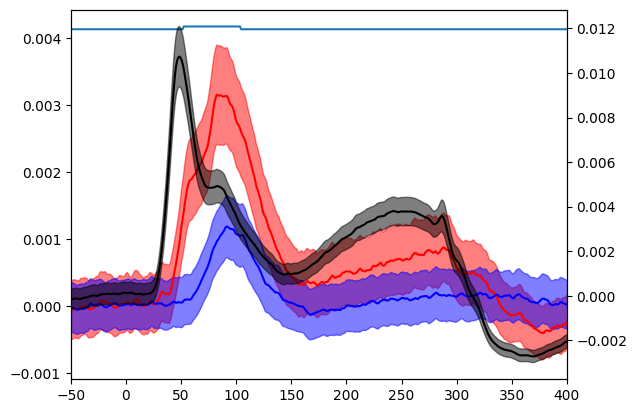

In [ ]:
cp_rf_array = np.concatenate(cp_rf)
cp_no_rf_array = np.concatenate(cp_no_rf)
v1_array = np.concatenate(v1)

print(f'CP RF: {cp_rf_array.shape[0]}')
print(f'CP No RF: {cp_no_rf_array.shape[0]}')
print(f'V1: {v1_array.shape[0]}')

mean0 = lambda x: np.mean(x, axis=0)
sem0 = lambda x: np.std(x, axis=0)/x.shape[0]**0.5
time = np.linspace(-250, 500, 750)

fig, ax = plt.subplots()
ax2 = ax.twinx()
colors = ['r', 'b', 'k']
for array, color, a in zip([cp_rf_array, cp_no_rf_array, v1_array], colors, [ax, ax, ax2]):

    mean = mean0(array)
    sem = sem0(array)

    a.plot(time, mean, color=color)
    a.fill_between(time, mean-sem, mean+sem, color=color, alpha=0.5)

ax.set_xlim([-50, 400])

cp_rf_no_rf_pval = [scipy.stats.ranksums(rf_time, no_rf_time)[1] for rf_time, no_rf_time in zip(cp_rf_array.T, cp_no_rf_array.T)]
corrected_sig = statsmodels.stats.multitest.fdrcorrection(cp_rf_no_rf_pval)[0]
ylim = ax.get_ylim()
ax.plot(time, corrected_sig*ylim[1]*0.01+ylim[1])

#fig.savefig('v1_cp_rf_norf_mean_response.pdf')


In [68]:
v1_tensor_file = r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\dg_active_unit_tensor_VISp_bursts.hdf5"
v1_random_tensor_file = r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\dg_active_unit_tensor_VISp_random_times.hdf5"
v1_tensor = h5py.File(v1_tensor_file)
v1_random_tensor = h5py.File(v1_random_tensor_file)

# m1_tensor_file = r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\dg_active_unit_tensor_MOp_bursts.hdf5"
# m1_tensor = h5py.File(m1_tensor_file)

In [72]:
sem = lambda x: np.std(x, axis=0)/len(x)**0.5
mean0 = lambda x: np.mean(x, axis=0)
unpack_lists = lambda x: [ss for s in x for ss in s]
base_sub_array = lambda x: x - np.mean(x, axis=1)[:, None]

for area_of_interest in ['CP']:

    sessions = session_dict['VISp'][area_of_interest]
    rf_coherence = []
    no_rf_coherence = []
    rf_mean = []
    no_rf_mean = []
    for session_id in sessions:
        session_tensor = v1_tensor[session_id]
        session_random_tensor = v1_random_tensor[session_id]

        sess_ccgs = session_data[session_id]['ccgs']['VISp']['VISp']
        good_traces = get_qualifying_autoccgs(sess_ccgs, 0.1)

        session_units = tu.apply_good_units_filter(units_rf[units_rf['session']==int(session_id)])
        v1_sess_tensor = tu.get_tensor_by_unit_ids(session_units[session_units['structure_acronym']=='VISp']['unit_id'].values, session_tensor)

        v1_means = np.mean(v1_sess_tensor, axis=0)
        v1_mean_binned = np.mean(np.reshape(v1_means, (v1_means.shape[0], 400, 10)), axis=2)

        area_units = session_units[session_units['structure_acronym']==area_of_interest]

        # if area_units['is_sig_rf'].sum()<10:
        #     continue


        for rf_or_not, coh_agg, mean_agg in zip([area_units['is_sig_rf'], ~area_units['is_sig_rf']], [rf_coherence, no_rf_coherence], [rf_mean, no_rf_mean]):

            if np.sum(rf_or_not)==0:
                continue

            rf_area_tensor = tu.get_tensor_by_unit_ids(area_units[rf_or_not]['unit_id'].values, session_tensor)
            rf_area_random_tensor = tu.get_tensor_by_unit_ids(area_units[rf_or_not]['unit_id'].values, session_random_tensor)
            
            mean = np.mean(rf_area_tensor, axis=0)
            mean_binned = np.mean(np.reshape(mean, (mean.shape[0], 400, 10)), axis=2)
            print(rf_area_tensor.shape)
            freqs, coh = multi_taper_coherence(base_sub_array(mean_binned[good_traces]), base_sub(v1_mean_binned[good_traces]), fs=100)

            random_mean = np.mean(rf_area_random_tensor, axis=0)
            random_mean_binned = np.mean(np.reshape(random_mean, (random_mean.shape[0], 400, 10)), axis=2)
            freqs, rand_coh = multi_taper_coherence(base_sub_array(random_mean_binned[good_traces]), base_sub_array(v1_mean_binned[good_traces]), fs=100)


            coh_agg.append(np.array(coh) - np.array(rand_coh))
            mean_agg.append(mean_binned[good_traces])

    if len(rf_coherence)==0:
        continue
    
    rf_coherence = np.array(unpack_lists(rf_coherence))
    rf_coherence = np.array([r for r in rf_coherence if not np.any(np.isnan(r))])
    no_rf_coherence = np.array(unpack_lists(no_rf_coherence))
    #diff = rf_coherence - no_rf_coherence

    rf_mean = np.array(unpack_lists(rf_mean))
    no_rf_mean = np.array(unpack_lists(no_rf_mean))


    area_rf_coh = np.nanmean(rf_coherence, axis=0)
    area_rf_coh_sem = np.nanstd(rf_coherence, axis=0)/len(rf_coherence)**0.5
    area_no_rf_coh = np.nanmean(no_rf_coherence, axis=0)
    area_no_rf_coh_sem = np.nanstd(no_rf_coherence, axis=0)/len(no_rf_coherence)**0.5

    # diff_mean = np.mean(diff, axis=0)
    # diff_sem = np.std(diff, axis=0)/diff.shape[0]**0.5


    rf_mean_basesub = base_sub_array(rf_mean)
    no_rf_mean_basesub = base_sub_array(no_rf_mean)

    rf_mean_trace = np.mean(rf_mean, axis=0)
    no_rf_mean_trace = np.mean(no_rf_mean_basesub, axis=0)


(19, 96, 4000)
(56, 96, 4000)
(24, 342, 4000)
(16, 342, 4000)
(23, 250, 4000)
(36, 250, 4000)
(13, 80, 4000)
(25, 80, 4000)
(1, 10, 4000)
(72, 10, 4000)


In [70]:
ind_band_low = np.searchsorted(freqs, 3)
ind_band_high = np.searchsorted(freqs, 7)

rf_band = np.mean(rf_coherence[:, ind_band_low:ind_band_high], axis=1)
no_rf_band = np.mean(no_rf_coherence[:, ind_band_low:ind_band_high], axis=1)

scipy.stats.wilcoxon(rf_band, no_rf_band)


WilcoxonResult(statistic=28158.0, pvalue=3.760576319098457e-14)

CP RF coherence: (201,)
CP No RF coherence: (439, 250)
CP RF 4Hz mean: (439, 250)
CP No RF 4Hz mean: (439, 250)


(-0.5, 1.5)

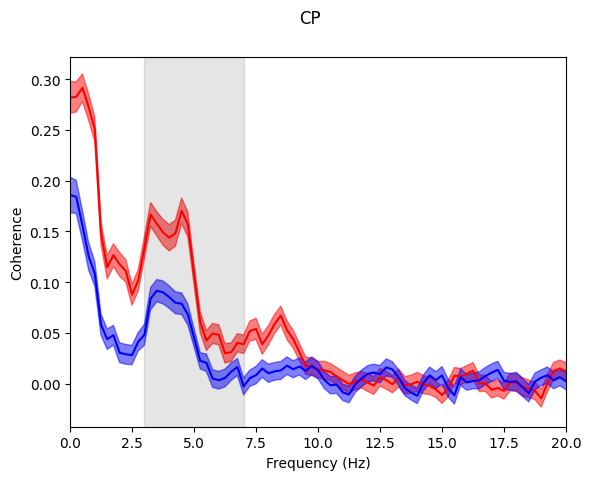

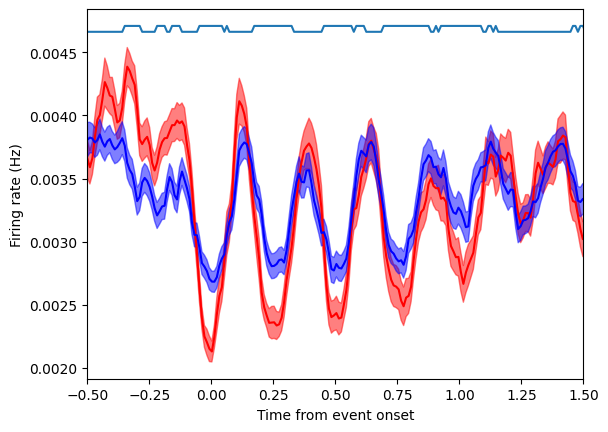

In [71]:
sem = lambda x: np.std(x, axis=0)/len(x)**0.5
mean0 = lambda x: np.mean(x, axis=0)
unpack_lists = lambda x: [ss for s in x for ss in s]
base_sub_array = lambda x: x - np.mean(x, axis=1)[:, None]

fig, ax = plt.subplots()
fig.suptitle(area_of_interest)

ax.plot(freqs, area_rf_coh, 'r')
ax.fill_between(freqs, area_rf_coh+area_rf_coh_sem, area_rf_coh-area_rf_coh_sem, color='r', alpha=0.5)
ax.plot(freqs, area_no_rf_coh, 'b')
ax.fill_between(freqs, area_no_rf_coh+area_no_rf_coh_sem, area_no_rf_coh-area_no_rf_coh_sem, color='b', alpha=0.5)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Coherence')
# ax.plot(freqs, diff_mean)
# ax.fill_between(freqs, diff_mean - diff_sem, diff_mean+diff_sem, alpha=0.5)
ax.axvspan(3,7, color='k', alpha=0.1)
ax.set_xlim(0,20)
fig.savefig('CP_rf_norf_coherence.pdf')

rf_mean_basesub = base_sub_array(rf_mean)[:, 150:]
no_rf_mean_basesub = base_sub_array(no_rf_mean)[:, 150:]

rf_mean_basesub = rf_mean[:, 150:]
no_rf_mean_basesub = no_rf_mean[:, 150:]

rf_mean_basesub = np.array([exponential_convolve(r) for r in rf_mean_basesub])
no_rf_mean_basesub = np.array([exponential_convolve(r) for r in no_rf_mean_basesub])

mean_sig_pvalues = np.array([scipy.stats.wilcoxon(rf_time, no_rf_time)[1] for rf_time, no_rf_time in zip(rf_mean_basesub.T, no_rf_mean_basesub.T)])
corrected_sig = statsmodels.stats.multitest.fdrcorrection(mean_sig_pvalues)[0]



print(f'CP RF coherence: {area_rf_coh.shape}')
print(f'CP No RF coherence: {no_rf_mean_basesub.shape}')
print(f'CP RF 4Hz mean: {rf_mean_basesub.shape}')
print(f'CP No RF 4Hz mean: {no_rf_mean_basesub.shape}')
 
time = np.linspace(-0.5, 2, 250)
fig, ax = plt.subplots()
ax.plot(time, (mean0(rf_mean_basesub)), 'r')
ax.fill_between(time, mean0(rf_mean_basesub)+sem(rf_mean_basesub), mean0(rf_mean_basesub)-sem(rf_mean_basesub), color='r', alpha=0.5)
ax.plot(time, mean0(no_rf_mean_basesub), 'b')
ax.fill_between(time, mean0(no_rf_mean_basesub)+sem(no_rf_mean_basesub), mean0(no_rf_mean_basesub)-sem(no_rf_mean_basesub), color='b', alpha=0.5)
ylim = ax.get_ylim()
ax.plot(time, corrected_sig*ylim[1]*0.01+ylim[1])

ax.set_xlabel('Time from event onset')
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlim(-0.5, 1.5)

#fig.savefig('CP_rf_norf_mean_trace.pdf')
